In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import roc_auc_score
import tensorflow
tensorflow.random.set_seed(2)

In [2]:
import pandas as pd
import numpy as np
data_sarcastic = pd.read_csv('Sarcasm_Hindi_Tweets-SARCASTIC.csv')
data_non_sarcastic = pd.read_csv('Sarcasm_Hindi_Tweets-NON-SARCASTIC.csv')
data_sarcastic['label'] = 'sarcastic'
data_non_sarcastic['label'] = 'non_sarcastic'
df = pd.concat([data_sarcastic, data_non_sarcastic], axis=0)
df = df.drop(['username','acctdesc','location','following','followers', 'totaltweets', 'usercreatedts', 'tweetcreatedts', 'retweetcount', 'hashtags'] ,axis=1)
df = df.reset_index()
df = df.drop('index',axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16179 entries, 0 to 16178
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16179 non-null  object
 1   label   16179 non-null  object
dtypes: object(2)
memory usage: 252.9+ KB


In [3]:
df.head()

text      label
0  हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...  sarcastic
1  हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...  sarcastic
2  हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...  sarcastic
3  हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...  sarcastic
4  हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...  sarcastic

In [4]:
import string
from tqdm import tqdm
from tqdm.notebook import tqdm

import nltk
from nltk.tokenize import word_tokenize

In [5]:
import gensim
import seaborn as sns

In [6]:
def count_length():
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))
    
count_length()

In [7]:
df.head()

text      label  word_count
0  हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...  sarcastic          58
1  हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...  sarcastic          58
2  हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...  sarcastic          58
3  हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...  sarcastic          58
4  हमारे गांव में एक मास्टर जी रहते थे, वो मोहल्ल...  sarcastic          58

In [8]:
df.tail()

text          label  \
16174  स्वर्गीय श्री सुशांत सिंह राजपूत ने हमें छिछोर...  non_sarcastic   
16175  बॉलीवुड एक्टर #सुशांत_सिंह_राजपूत ने #फांसी लग...  non_sarcastic   
16176  #SushantSinghRajput #Suicide  क्यों?? चमक धमक ...  non_sarcastic   
16177  हर हाल में #खुश रहना सीख लो🙃\n        उस दिल क...  non_sarcastic   
16178  इतना कुछ पाने के बाद भी अगर इंसान जिदंगी से हा...  non_sarcastic   

       word_count  
16174          36  
16175          45  
16176          40  
16177          47  
16178          48

In [9]:
import re
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [10]:
for i in tqdm(range(len(df))):
    df['text'][i] = emoji_pattern.sub(r'', df['text'][i])
count_length()

  0%|          | 0/16179 [00:00<?, ?it/s]

C:\Users\PRERNA MISHRA\AppData\Local\Temp\ipykernel_21480\1369599250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'][i] = emoji_pattern.sub(r'', df['text'][i])


In [11]:
df.tail()

text          label  \
16174  स्वर्गीय श्री सुशांत सिंह राजपूत ने हमें छिछोर...  non_sarcastic   
16175  बॉलीवुड एक्टर #सुशांत_सिंह_राजपूत ने #फांसी लग...  non_sarcastic   
16176  #SushantSinghRajput #Suicide  क्यों?? चमक धमक ...  non_sarcastic   
16177  हर हाल में #खुश रहना सीख लो\n        उस दिल को...  non_sarcastic   
16178  इतना कुछ पाने के बाद भी अगर इंसान जिदंगी से हा...  non_sarcastic   

       word_count  
16174          36  
16175          45  
16176          40  
16177          47  
16178          48

In [12]:
# Using ChatGPT creating stop words and using that 

stopwords_hindi = ['आपका','अंदर', 'अत', 'अपना', 'अपनी', 'अपने', 'अभी', 'आदि', 'आप',
                   'इत्यादि', 'इन', 'इनका', 'इन्हीं', 'इन्हें', 'इन्हों', 'इस', 'इसका', 'इसकी',
                   'इसके', 'इसमें', 'इसी', 'इसे', 'उन', 'उनका', 'उनकी', 'उनके', 'उनको',
                   'उन्हीं', 'उन्हें', 'उन्हों', 'उस', 'उसके', 'उसी', 'उसे', 'एक', 'एवं', 'एस',
                   'ऐसे', 'और', 'कई', 'कर','करता', 'करते', 'करना', 'करने', 'करें', 'कहते', 'कहा',
                   'का', 'काफ़ी', 'कि', 'कितना', 'किन्हें', 'किन्हों', 'किया', 'किर', 'किस', 'किसी', 'किसे',
                   'की', 'कुछ', 'कुल', 'के', 'को', 'कोई', 'कौन', 'कौनसा', 'गया', 'घर', 'जब', 'जहाँ',
                   'जा', 'जितना', 'जिन', 'जिन्हें', 'जिन्हों', 'जिस', 'जिसे', 'जीधर', 'जैसा', 'जैसे', 'जो',
                   'तक', 'तब', 'तरह', 'तिन', 'तिन्हें', 'तिन्हों', 'तिस', 'तिसे', 'तो', 'था', 'थी', 'थे',
                   'दबारा', 'दिया', 'दुसरा', 'दूसरे', 'दो', 'द्वारा', 'न', 'नहीं', 'ना', 'निहायत', 'नीचे', 'ने',
                   'पर', 'पर', 'पहले', 'पूरा', 'पे', 'फिर', 'बनी', 'बही', 'बहुत', 'बाद', 'बाला', 'बिलकुल',
                   'भी', 'भीतर', 'मगर', 'मानो', 'मे', 'में', 'यदि', 'यह', 'यहाँ', 'यही', 'या'
                  'तुम','मेरी','मुझे','क्योंकि','हम','प्रति','अबकी','आगे','माननीय','शहर','बताएं','कौनसी'
                   'क्लिक','किसकी','बड़े','मैं','and','रही','आज','लें','आपके','मिलकर','सब','मेरे','जी'
                   'श्री', 'यिह', 'ये', 'रखें', 'रहा', 'रहे', 'ऱ्वासा', 'लिए', 'लिये', 'लेकिन', 'व', 'वर्ग', 'वह',
                   'वहाँ', 'वहीं', 'वाले', 'वुह', 'वे', 'वग़ैरह', 'संग', 'सकता', 'सकते', 'सबसे', 'सभी', 'साथ',
                   'साबुत', 'साभ', 'सारा', 'से', 'सो', 'ही', 'हुआ', 'हुई', 'हुए', 'है', 'हैं', 'हो', 'होता', 'होती',
                   'होते', 'होना', 'होने', 'अपनि', 'जेसे', 'होति', 'सभि', 'तिंहों', 'इंहों', 'दवारा', 'इसि', 'किंहें',
                   'थि', 'उंहों', 'ओर', 'जिंहें', 'वहिं', 'अभि', 'बनि', 'हि', 'उंहिं', 'उंहें', 'हें', 'वगेरह', 'एसे',
                   'रवासा', 'कोन', 'निचे', 'काफि', 'उसि', 'पुरा', 'भितर', 'हे', 'बहि', 'वहां', 'कोइ', 'यहां',
                   'जिंहों', 'तिंहें', 'किसि', 'कइ', 'यहि', 'इंहिं', 'जिधर', 'इंहें', 'अदि', 'इतयादि', 'हुइ', 'कोनसा',
                   'इसकि', 'दुसरे', 'जहां', 'अप', 'किंहों', 'उनकि', 'भि', 'वरग', 'हुअ', 'जेसा', 'नहिं']

stopwords_english = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're",
                "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him',
                'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its',
                'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who',
                'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was',
                'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did',
                'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
                'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
                'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
                'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
                'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
                'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
                'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should',
                "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't",
                'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
                "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
                "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
                "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

stopwords = stopwords_hindi + stopwords_english


In [13]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\PRERNA
[nltk_data]     MISHRA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
def processText(text):
    text = text.lower()
    
    text = re.sub('((www.[^s]+)|(https?://[^s]+))','',text)
    text = re.sub('@[^s]+','',text)
    text = re.sub('[s]+', ' ', text)
    text = re.sub(r'#([^s]+)', '', text)
    
    tokenized_text = word_tokenize(text)
    print(tokenized_text)
    
    output_string = ''
    
    for each in tokenized_text:
        if ( each not in string.punctuation and each not in stopwords and len(each) > 1 ):
            output_string += each + ' '


    return output_string

In [15]:
df['text'][0]
processText(df['text'][0])

['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोहल्ले', 'के', 'बच्चों', 'को', 'अपने', 'स्कूल', 'आने', 'को', 'कहते', 'थे।', 'जब', 'मैं', 'बड़ा', 'हुआ', 'तो', 'पता', 'चला-', 'स्कूल', 'मास्टर', 'के', 'बेटे', 'का', ',', 'बस', 'उनके', 'भतीजे', 'की', ',', 'कैंटीन', 'उनके', 'भांजे', 'की', 'और', 'पढ़ाने', 'वाले', 'भी', 'सब', 'उनके', 'रिश्तेदार', 'ही', 'थे', '..', '!', 'आज', 'मास्टर', 'जी', 'में', 'सरकार', 'में', 'मंत्री', 'हैं', '.', '!']


'हमारे गांव मास्टर जी रहते वो मोहल्ले बच्चों स्कूल आने थे। बड़ा पता चला- स्कूल मास्टर बेटे बस भतीजे कैंटीन भांजे पढ़ाने रिश्तेदार .. मास्टर जी सरकार मंत्री '

In [16]:
tqdm.pandas()
df['text'] = df['text'].progress_apply(processText)
count_length()

  0%|          | 0/16179 [00:00<?, ?it/s]

['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोहल्ले', 'के', 'बच्चों', 'को', 'अपने', 'स्कूल', 'आने', 'को', 'कहते', 'थे।', 'जब', 'मैं', 'बड़ा', 'हुआ', 'तो', 'पता', 'चला-', 'स्कूल', 'मास्टर', 'के', 'बेटे', 'का', ',', 'बस', 'उनके', 'भतीजे', 'की', ',', 'कैंटीन', 'उनके', 'भांजे', 'की', 'और', 'पढ़ाने', 'वाले', 'भी', 'सब', 'उनके', 'रिश्तेदार', 'ही', 'थे', '..', '!', 'आज', 'मास्टर', 'जी', 'में', 'सरकार', 'में', 'मंत्री', 'हैं', '.', '!']
['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोहल्ले', 'के', 'बच्चों', 'को', 'अपने', 'स्कूल', 'आने', 'को', 'कहते', 'थे।', 'जब', 'मैं', 'बड़ा', 'हुआ', 'तो', 'पता', 'चला-', 'स्कूल', 'मास्टर', 'के', 'बेटे', 'का', ',', 'बस', 'उनके', 'भतीजे', 'की', ',', 'कैंटीन', 'उनके', 'भांजे', 'की', 'और', 'पढ़ाने', 'वाले', 'भी', 'सब', 'उनके', 'रिश्तेदार', 'ही', 'थे', '..', '!', 'आज', 'मास्टर', 'जी', 'में', 'सरकार', 'में', 'मंत्री', 'हैं', '.', '!']
['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोह

['har', 'baat', 'pe', 'rulate', 'ho', '...', 'in', 'aan', 'ho', 'ya', 'pyaaz', '...']
['शिक्षा', 'में', 'क्रांति', 'करने', 'के', 'बाद', 'जैसे', 'ही', 'क्रांतिवीर', 'मनीष', 'सिसोदिया', 'ने', 'दिल्ली', 'के', 'स्वास्थ्य', 'मंत्रालय', 'का', 'कार्यभार', 'संभाला', '3137', 'कोरोना', 'संक्रमितों', 'का', 'नया', 'कीर्तिमान', 'और', 'कोरोना', 'मामलों', 'का', 'अर्धशतक', '53116', 'बना', 'बैठे']
[]
['jinhe', 'a', 'al', 'zindigi', 'mein', 'kabz', 'ki', 'bimaari', 'hai', 'vo', 'ocial', 'media', 'par', 'hugg', 'rhe', 'hain']
['bhai', 'u', 'ko']
['u', 'ki', 'daal', 'gal', 'bhi', 'jaegi', 'or', 'pakk', 'bhi', 'jaegi', 'tum', 'ba', 'itti', 'k', 'bajne', 'ka', 'wait', 'karte', 'rhna']
['he', ':', 'ek', 'baat', 'puchu', 'achi', 'baatao', 'gai', '?', '?', 'me', ':', 'haan', 'pucho', 'lo', '?', '?', 'he', ':', 'tum', 'mere', 'iva', 'ki', 'i', 'aur', 'e', 'pyaar', 'toh', 'nai', 'karte', 'na', '?', '?', 'me', ':', 'nahi', '!', 'he', ':', 'aachi', 'baatao', '!', '?', '?', '?', '?', 'me', '*']
['he', ':', 'ek', 'b

['चीन', 'के', 'मुद्दे', 'पर', 'ओवैसी', 'इतना', 'गुस्से', 'में', 'है', ',', 'कि', 'वो', 'अभी', '``', 'शी', 'जिन', 'पिंग', "''", 'को', '5', 'मिनट', 'के', 'लिए', 'चीनी', 'आर्मी/', 'पुलिस', 'हटाने', 'को', 'कह', ',', 'पूरे', 'चीन', 'को', 'खत्म', 'कर', 'देगा', '..']
['चीन', 'के', 'मुद्दे', 'पर', 'ओवैसी', 'इतना', 'गुस्से', 'में', 'है', ',', 'कि', 'वो', 'अभी', '``', 'शी', 'जिन', 'पिंग', "''", 'को', '5', 'मिनट', 'के', 'लिए', 'चीनी', 'आर्मी/', 'पुलिस', 'हटाने', 'को', 'कह', ',', 'पूरे', 'चीन', 'को', 'खत्म', 'कर', 'देगा', '..']
['चीन', 'के', 'मुद्दे', 'पर', 'ओवैसी', 'इतना', 'गुस्से', 'में', 'है', ',', 'कि', 'वो', 'अभी', '``', 'शी', 'जिन', 'पिंग', "''", 'को', '5', 'मिनट', 'के', 'लिए', 'चीनी', 'आर्मी/', 'पुलिस', 'हटाने', 'को', 'कह', ',', 'पूरे', 'चीन', 'को', 'खत्म', 'कर', 'देगा', '..']
['चीन', 'के', 'मुद्दे', 'पर', 'ओवैसी', 'इतना', 'गुस्से', 'में', 'है', ',', 'कि', 'वो', 'अभी', '``', 'शी', 'जिन', 'पिंग', "''", 'को', '5', 'मिनट', 'के', 'लिए', 'चीनी', 'आर्मी/', 'पुलिस', 'हटाने', 'को', 'कह', ',', 'पूरे

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
[]
[]
['अभी', 'नाज़', 'है', 'टूटे', 'दिल', 'को', 'वफ़ा', 'पे', ',', 'के', 'टूटेंगे', 'सारे', 'भरम', 'धीरे', 'धीरे', '!', '~', 'भक्त']
[]
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी'

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्ब

['अरे', 'सीमा', 'पर', 'तो', 'रोज', 'ही', 'जवान', 'मरते', 'हैं', ',', 'अब', 'क्या', 'हर', 'रोज', 'ही', 'अफसोस', 'थोडी', 'करते', 'हैं।', 'उसका', 'घर', 'तो', 'अब', ',', 'सरकार', 'चलाती', 'है', 'ना', ',', 'बाप', ',', 'बेटे', ',', 'और', 'पति', 'की', 'प्यास', 'तो', ',', 'वही', 'बुझाती', 'है', 'ना।', 'खैर', 'छोडो', 'यार', ',', 'सैनिक', 'था', 'उसे', 'तो', 'मरना', 'ही', 'था।']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'प

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्ब

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्ब

[]
['h', 'बिना', 'बीवी', 'वालों', 'को', 'तो', 'कोई', 'मकान', 'किराए', 'पर', 'नहीं', 'देता', 'इन्होंने', 'देश', 'दे', 'दिया।']
['आज', 'तो', 'चीन', 'की', 'ख़ैर', 'नहीं', ',', 'टुकड़े-टुकड़े', 'कर', 'देंगे', 'हमारे', 'tv', 'चैनल', 'वाले', '!', 'शाम', 'तक', 'कड़ी', 'निंदा', 'भी', 'हो', 'जाएगी', ',', 'देख', 'लेना', '!']
['मैं', 'उस', 'रक्षा', 'विशेषज्ञ', 'को', 'दो', 'शब्द', 'लेकर', 'खोज', 'रहा', 'हूं', ',', 'जिसने', 'कहा', 'था', ',', 'चीन', 'से', 'हमें', 'कोई', 'खतरा', 'है', 'ही', 'नहीं', 'क्योंकि', 'वहां', 'वाले', 'तो', 'मां-बाप', 'की', 'इकलौती', 'औलाद', 'होते', 'हैं।', '@', 'udhirchaudhary', 'कहीं', 'ये', 'आप', 'तो', 'नहीं', '?']
['एक', 'पड़ोसी', 'टिड्डी', 'भेज', 'रहा', '..', 'एक', 'पड़ोसी', 'कोरोना', 'भेज', 'रहा', 'और', 'लद्दाख', 'में', 'टेंट', 'भी', 'गाड़', 'रहा', '..', 'एक', 'पड़ोसी', 'मन', 'मर्जी', 'के', 'नक्शे', 'छाप', 'रहा', 'है', '..', '।', '।', '।', '।', '।', '।', 'श्रीलंका', ',', 'भाई', 'तु', 'क्यो', 'शरमा', 'रहा', 'है।', 'आजा', 'तू', 'भी', 'रावण', 'कि', 'मौत', 'का', 'बदला', 'लेल

['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोहल्ले', 'के', 'बच्चों', 'को', 'अपने', 'स्कूल', 'आने', 'को', 'कहते', 'थे।', 'जब', 'मैं', 'बड़ा', 'हुआ', 'तो', 'पता', 'चला-', 'स्कूल', 'मास्टर', 'के', 'बेटे', 'का', ',', 'बस', 'उनके', 'भतीजे', 'की', ',', 'कैंटीन', 'उनके', 'भांजे', 'की', 'और', 'पढ़ाने', 'वाले', 'भी', 'सब', 'उनके', 'रिश्तेदार', 'ही', 'थे', '..', '!', 'आज', 'मास्टर', 'जी', 'में', 'सरकार', 'में', 'मंत्री', 'हैं', '.', '!']
['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोहल्ले', 'के', 'बच्चों', 'को', 'अपने', 'स्कूल', 'आने', 'को', 'कहते', 'थे।', 'जब', 'मैं', 'बड़ा', 'हुआ', 'तो', 'पता', 'चला-', 'स्कूल', 'मास्टर', 'के', 'बेटे', 'का', ',', 'बस', 'उनके', 'भतीजे', 'की', ',', 'कैंटीन', 'उनके', 'भांजे', 'की', 'और', 'पढ़ाने', 'वाले', 'भी', 'सब', 'उनके', 'रिश्तेदार', 'ही', 'थे', '..', '!', 'आज', 'मास्टर', 'जी', 'में', 'सरकार', 'में', 'मंत्री', 'हैं', '.', '!']
['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोह

['i', 'called', 'my', 'friend', 'who', 'follow', '``', 'mayan', 'calender', "''", 'me', ':', 'bhai', 'vo', '21', 't', 'jun', 'aagaya', 'kuch', 'huva', 'nahee', 'abheetak', 'friend', ':', 'din', 'abhitak', 'khatam', 'nahee', 'huva', 'hai', '...', 'ummid', 'pe', 'duniya', 'kaayam', 'hai']
['hwi', 'rajmeena', 'hibagree', 'तो', 'उसमे']
['ghamand', 'na', 'kar', 'mere', 'do', 't', 'uraj', 'aaj', 'chand', 'ban', 'gya', 'tu', 'to', 'in', 'aan', 'hai', '..']
['ghamand', 'na', 'kar', 'mere', 'do', 't', 'uraj', 'aaj', 'chand', 'ban', 'gya', 'tu', 'to', 'in', 'aan', 'hai', '..']
['koi', 'toh', 'bol', 'raha', 'tha', 'aaj', 'duniya', 'khatam', 'hone', 'wali', 'hai', '..', 'kaha', 'hai', 'wo', 'log', '?']
['lolz', '!', 'mu', 'haraf', 'ki', 'baqiyaat', 'ab', 'civil', 'upremacy', 'ki', 'tabeleegh', 'dy', 'rahy', '..']
['हम', 'भारतीय', 'की', 'देशभक्ति', 'देखनी', 'है', 'किसी', 'को', '...', '?', 'ठीक', 'है', 'flipcart', 'पर', 'redmi', 'फ़ोन', 'का', 'ell', 'लगने', 'दो', '।', 'आउट', 'ऑफ', 'स्टॉक', 'होते', '

['योगी', 'जी', 'चाहे', 'तो', 'तुरंत', 'भारत', 'को', 'corona', 'मुक्त', 'कर', 'सकते', 'है।', 'बस', 'उन्हें', 'भारत', 'का', 'नाम', 'बदलकर', 'न्यूजीलैंड', 'रखना', 'है।']
['मीडिया', 'को', 'कांग्रेस', 'अध्यक्षा', 'से', 'ये', 'पूछना', 'ही', 'चाहिए', ',', 'कि', 'भक्तों', 'के', 'भगवान', 'से', 'ऐसा', 'सवाल', 'ही', 'क्यों', 'पूछा', 'जिसका', 'जवाब', 'ही', 'नहीं', 'आता', 'था', '।।', 'कांग्रेस', 'देशद्रोही', 'है', '?', '?']
['अभी', '3', 'महीने', 'का', 'रिचार्ज', 'करवाया', 'है', 'फोन', 'का।तब', 'तक', 'के', 'लिए', 'रुक', 'जाओ', 'यार']
['दिल्ली', 'के', 'स्वास्थ्य', 'मंत्री', '@', 'atyendarjain', 'को', 'दिल्ली', 'के', 'सरकारी', 'अस्पताल', 'से', 'निकाल', 'कर', 'दिल्ली', 'के', 'प्राइवेट', 'अस्पताल', 'में', 'भर्ती', 'कराया', 'गया', 'है', 'इतने', 'पर', 'भी', 'ये', 'दिल्लीवाले', 'बोल', 'रहे', 'हैं', 'की', 'atyendrajain']
['ख़ुशनसीब', 'हो', 'तुम', ',', 'जो', 'मन', 'मार', 'कर', 'जी', 'रहे', 'हो।', 'जमाने', 'मे', 'तो', 'लोगो', 'ने', 'अपनी', 'भूख', 'को', 'मार', 'रखा', 'है।।।।।']
['ख़ुशनसीब', 'हो', 'तुम', ',', '

['.', 'blokli', 't', 'ka', 'pata', 'nahi', 'par', 'ignore', 'li', 't', 'bahut', 'e', 'chutiyon', 'e', 'bhari', 'padi', 'hai', '.']
['ipl', 'की', 'टीम', 'c', 'k', 'की', 'टीम', 'के', 'डॉक्टर', 'डॉ', 'मधु', 'थोट्टापपिल्लई', 'को', 'उनके', 'द्वारा', 'किए', 'गए', 'एक']
['once', 'a', 'wi', 'e', 'man', 'aid', '“', 'jab', 'tak', 'i', 'de', 'h', 'm', 'aneema', 'hai', 'log', 'chutiye', 'bante', 'rahenge', '”', '-', 'ft.', 'ramadheer', 'ingh']
[]
['अगर', 'आज', 'नेहरू', 'होते', 'तो', ',', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', ',', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '....', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '.', 'नेहरू', 'की', 'किताब', ',', '(', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'आक', 'थू', '..', 'कांग्रेस', '....']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', '

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्ब

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्ब

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्ब

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्ब

['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोहल्ले', 'के', 'बच्चों', 'को', 'अपने', 'स्कूल', 'आने', 'को', 'कहते', 'थे।', 'जब', 'मैं', 'बड़ा', 'हुआ', 'तो', 'पता', 'चला-', 'स्कूल', 'मास्टर', 'के', 'बेटे', 'का', ',', 'बस', 'उनके', 'भतीजे', 'की', ',', 'कैंटीन', 'उनके', 'भांजे', 'की', 'और', 'पढ़ाने', 'वाले', 'भी', 'सब', 'उनके', 'रिश्तेदार', 'ही', 'थे', '..', '!', 'आज', 'मास्टर', 'जी', 'में', 'सरकार', 'में', 'मंत्री', 'हैं', '.', '!']
['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोहल्ले', 'के', 'बच्चों', 'को', 'अपने', 'स्कूल', 'आने', 'को', 'कहते', 'थे।', 'जब', 'मैं', 'बड़ा', 'हुआ', 'तो', 'पता', 'चला-', 'स्कूल', 'मास्टर', 'के', 'बेटे', 'का', ',', 'बस', 'उनके', 'भतीजे', 'की', ',', 'कैंटीन', 'उनके', 'भांजे', 'की', 'और', 'पढ़ाने', 'वाले', 'भी', 'सब', 'उनके', 'रिश्तेदार', 'ही', 'थे', '..', '!', 'आज', 'मास्टर', 'जी', 'में', 'सरकार', 'में', 'मंत्री', 'हैं', '.', '!']
['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोह

['nibbii', '-', '3,4', 'boyfriend', 'banane', 'ke', 'bad', '~', '(', 'pyaar', 'andha', 'hota', 'hai🥀', 'me', '-', 'beta', 'pyaar', 'andha', 'nhi', 'hota', '...', 'tune', '``', 'andhadhun', "''", 'pyar', 'kiya', 'hai', '🤫🤣', '.', '.']
['guy2020', 'ealione', 'a', 'laga', 'hota', 'hai', 'wo', 'bhi', 'twitter', 'pe', 'aurto', 'ko', 'gaali', 'de', 'dete', 'hai', '..']
['दिल्ली', 'के', 'स्वास्थ्य', 'मंत्री', '@', 'atyendarjain', 'को', 'दिल्ली', 'के', 'सरकारी', 'अस्पताल', 'से', 'निकाल', 'कर', 'दिल्ली', 'के', 'प्राइवेट', 'अस्पताल', 'में', 'भर्ती', 'कराया', 'गया', 'है', 'इतने', 'पर', 'भी', 'ये', 'दिल्लीवाले', 'बोल', 'रहे', 'हैं', 'की', 'atyendrajain']
['band', 'geet', 'vi', 'hoo', 'jaan', 'ge', 'tu', 'i', 'hathyaar', 'tah', 'band', 'kardo']
['दिल्ली', 'के', 'स्वास्थ्य', 'मंत्री', '@', 'atyendarjain', 'को', 'दिल्ली', 'के', 'सरकारी', 'अस्पताल', 'से', 'निकाल', 'कर', 'दिल्ली', 'के', 'प्राइवेट', 'अस्पताल', 'में', 'भर्ती', 'कराया', 'गया', 'है', 'इतने', 'पर', 'भी', 'ये', 'दिल्लीवाले', 'बोल', 'रहे', 'ह

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
[]
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'ति

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['arca', 'm', 'word', 'pata', 'hai', 'kya', 'hota', 'hai', '?', 'ek', 'kaam', 'kar', ',', 'fridge', 'ka', 'door', 'open', 'kar', ',', 'freezer', 'e', 'ice', 'nikal', 'aur', 'laga', '!', '!', 'abb', 'ye', 'matt', 'poochna', 'kaha', 'pe', '!', '!']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', '

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्ब

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्ब

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्ब

['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोहल्ले', 'के', 'बच्चों', 'को', 'अपने', 'स्कूल', 'आने', 'को', 'कहते', 'थे।', 'जब', 'मैं', 'बड़ा', 'हुआ', 'तो', 'पता', 'चला-', 'स्कूल', 'मास्टर', 'के', 'बेटे', 'का', ',', 'बस', 'उनके', 'भतीजे', 'की', ',', 'कैंटीन', 'उनके', 'भांजे', 'की', 'और', 'पढ़ाने', 'वाले', 'भी', 'सब', 'उनके', 'रिश्तेदार', 'ही', 'थे', '..', '!', 'आज', 'मास्टर', 'जी', 'में', 'सरकार', 'में', 'मंत्री', 'हैं', '.', '!']
['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोहल्ले', 'के', 'बच्चों', 'को', 'अपने', 'स्कूल', 'आने', 'को', 'कहते', 'थे।', 'जब', 'मैं', 'बड़ा', 'हुआ', 'तो', 'पता', 'चला-', 'स्कूल', 'मास्टर', 'के', 'बेटे', 'का', ',', 'बस', 'उनके', 'भतीजे', 'की', ',', 'कैंटीन', 'उनके', 'भांजे', 'की', 'और', 'पढ़ाने', 'वाले', 'भी', 'सब', 'उनके', 'रिश्तेदार', 'ही', 'थे', '..', '!', 'आज', 'मास्टर', 'जी', 'में', 'सरकार', 'में', 'मंत्री', 'हैं', '.', '!']
['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोह

['शिक्षा', 'में', 'क्रांति', 'करने', 'के', 'बाद', 'जैसे', 'ही', 'क्रांतिवीर', 'मनीष', 'सिसोदिया', 'ने', 'दिल्ली', 'के', 'स्वास्थ्य', 'मंत्रालय', 'का', 'कार्यभार', 'संभाला', '3137', 'कोरोना', 'संक्रमितों', 'का', 'नया', 'कीर्तिमान', 'और', 'कोरोना', 'मामलों', 'का', 'अर्धशतक', '53116', 'बना', 'बैठे']
['शिक्षा', 'में', 'क्रांति', 'करने', 'के', 'बाद', 'जैसे', 'ही', 'क्रांतिवीर', 'मनीष', 'सिसोदिया', 'ने', 'दिल्ली', 'के', 'स्वास्थ्य', 'मंत्रालय', 'का', 'कार्यभार', 'संभाला', '3137', 'कोरोना', 'संक्रमितों', 'का', 'नया', 'कीर्तिमान', 'और', 'कोरोना', 'मामलों', 'का', 'अर्धशतक', '53116', 'बना', 'बैठे']
['शिक्षा', 'में', 'क्रांति', 'करने', 'के', 'बाद', 'जैसे', 'ही', 'क्रांतिवीर', 'मनीष', 'सिसोदिया', 'ने', 'दिल्ली', 'के', 'स्वास्थ्य', 'मंत्रालय', 'का', 'कार्यभार', 'संभाला', '3137', 'कोरोना', 'संक्रमितों', 'का', 'नया', 'कीर्तिमान', 'और', 'कोरोना', 'मामलों', 'का', 'अर्धशतक', '53116', 'बना', 'बैठे']
['शिक्षा', 'में', 'क्रांति', 'करने', 'के', 'बाद', 'जैसे', 'ही', 'क्रांतिवीर', 'मनीष', 'सिसोदिया', 'ने', 'द

['चीन', 'के', 'मुद्दे', 'पर', 'ओवैसी', 'इतना', 'गुस्से', 'में', 'है', ',', 'कि', 'वो', 'अभी', '``', 'शी', 'जिन', 'पिंग', "''", 'को', '5', 'मिनट', 'के', 'लिए', 'चीनी', 'आर्मी/', 'पुलिस', 'हटाने', 'को', 'कह', ',', 'पूरे', 'चीन', 'को', 'खत्म', 'कर', 'देगा', '..']
['चीन', 'के', 'मुद्दे', 'पर', 'ओवैसी', 'इतना', 'गुस्से', 'में', 'है', ',', 'कि', 'वो', 'अभी', '``', 'शी', 'जिन', 'पिंग', "''", 'को', '5', 'मिनट', 'के', 'लिए', 'चीनी', 'आर्मी/', 'पुलिस', 'हटाने', 'को', 'कह', ',', 'पूरे', 'चीन', 'को', 'खत्म', 'कर', 'देगा', '..']
['चीन', 'के', 'मुद्दे', 'पर', 'ओवैसी', 'इतना', 'गुस्से', 'में', 'है', ',', 'कि', 'वो', 'अभी', '``', 'शी', 'जिन', 'पिंग', "''", 'को', '5', 'मिनट', 'के', 'लिए', 'चीनी', 'आर्मी/', 'पुलिस', 'हटाने', 'को', 'कह', ',', 'पूरे', 'चीन', 'को', 'खत्म', 'कर', 'देगा', '..']
['zindgi', 'kitni', 'aa', 'an', 'ho', 'jati', 'agar', 'hum', 'ab', 'ye', 'fam', 'commentor', 'ki', 'baat', 'maan', 'lete', '..', 'par', 'nahi', '...']
['never', 'date', 'a', 'per', 'on', '``', 'who', 'i', 'on', 'diet'

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'होते', 'तो', ',', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', ',', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '....', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '.', 'नेहरू', 'की', 'किताब', ',', '(', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'आक', 'थू', '..', 'कांग्रेस', '....']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्ब

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्ब

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
[]
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'ति

['haydhawan', 'jo', 'ladki', 'ladke', 'ko', 'chhedti', 'hai', 'vo', 'a', 'hakt', 'ladki', 'hoti', 'hai', '.', 'vo', 'apne', 'maa', 'baap', 'aa', 'a', 'ur', 'pati', 'ya', 'ki', 'i', 'ko', 'bhi', 'jhoothe', 'ca', 'e', 'me', 'pha', 'a', 'akti', 'hai', '.']
['jindagi', 'me', 'mai', '2', 'hi', 'galati', 'baar-baar', 'krta', 'hoon', '..', 'pehla', 'to', 'ye', 'ki', 'mai', "'galati", 'karta', 'hoo', "'", 'aur', 'doo', 'ra', 'mai', 'ye', 'ochne', 'ochne', 'lagta', 'hoo', 'ki', 'ye', "'galati", 'maine', 'ki', 'kb', "'", '?']
['आँसु', 'आए', 'तो', 'खुद', 'पोंछना', ',', 'लोग', 'पोछेंगे', 'तो', 'सौदा', 'करेंगे', '!', '!', '!']
['आँसु', 'आए', 'तो', 'खुद', 'पोंछना', ',', 'लोग', 'पोछेंगे', 'तो', 'सौदा', 'करेंगे', '!', '!', '!']
['haydhawan', 'jo', 'ladki', 'ladke', 'ko', 'chhedti', 'hai', 'vo', 'a', 'hakt', 'ladki', 'hoti', 'hai', '.', 'vo', 'apne', 'maa', 'baap', 'aa', 'a', 'ur', 'pati', 'ya', 'ki', 'i', 'ko', 'bhi', 'jhoothe', 'ca', 'e', 'me', 'pha', 'a', 'akti', 'hai', '.']
['arca', 'm']
[]
['एक', 

['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोहल्ले', 'के', 'बच्चों', 'को', 'अपने', 'स्कूल', 'आने', 'को', 'कहते', 'थे।', 'जब', 'मैं', 'बड़ा', 'हुआ', 'तो', 'पता', 'चला-', 'स्कूल', 'मास्टर', 'के', 'बेटे', 'का', ',', 'बस', 'उनके', 'भतीजे', 'की', ',', 'कैंटीन', 'उनके', 'भांजे', 'की', 'और', 'पढ़ाने', 'वाले', 'भी', 'सब', 'उनके', 'रिश्तेदार', 'ही', 'थे', '..', '!', 'आज', 'मास्टर', 'जी', 'में', 'सरकार', 'में', 'मंत्री', 'हैं', '.', '!']
['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोहल्ले', 'के', 'बच्चों', 'को', 'अपने', 'स्कूल', 'आने', 'को', 'कहते', 'थे।', 'जब', 'मैं', 'बड़ा', 'हुआ', 'तो', 'पता', 'चला-', 'स्कूल', 'मास्टर', 'के', 'बेटे', 'का', ',', 'बस', 'उनके', 'भतीजे', 'की', ',', 'कैंटीन', 'उनके', 'भांजे', 'की', 'और', 'पढ़ाने', 'वाले', 'भी', 'सब', 'उनके', 'रिश्तेदार', 'ही', 'थे', '..', '!', 'आज', 'मास्टर', 'जी', 'में', 'सरकार', 'में', 'मंत्री', 'हैं', '.', '!']
['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोह

['almankhan', '.', 'almankhan', ':', 'to', 'all', 'tho', 'e', 'doubting', 'thoma', 'out', 'there', ',', 'dekho', 'bhai', 'ka', 'dil', 'kitna', 'bada', 'hai', '!', '!', 'aan', 'u', 'aa', 'gaye', 'yeh', 'padh', 'kar']
['शिक्षा', 'में', 'क्रांति', 'करने', 'के', 'बाद', 'जैसे', 'ही', 'क्रांतिवीर', 'मनीष', 'सिसोदिया', 'ने', 'दिल्ली', 'के', 'स्वास्थ्य', 'मंत्रालय', 'का', 'कार्यभार', 'संभाला', '3137', 'कोरोना', 'संक्रमितों', 'का', 'नया', 'कीर्तिमान', 'और', 'कोरोना', 'मामलों', 'का', 'अर्धशतक', '53116', 'बना', 'बैठे']
['हम', 'भारतीय', 'की', 'देशभक्ति', 'देखनी', 'है', 'किसी', 'को', '...', '?', 'ठीक', 'है', 'flipcart', 'पर', 'redmi', 'फ़ोन', 'का', 'ell', 'लगने', 'दो', '।', 'आउट', 'ऑफ', 'स्टॉक', 'होते', 'ही', 'समझ', 'जाना', 'china', 'का', 'किस', 'कदर', 'विरोध', 'कर', 'रहे', 'हम', 'सब', '।']
['almankhan', '.', 'almankhan', ':', 'to', 'all', 'tho', 'e', 'doubting', 'thoma', 'out', 'there', ',', 'dekho', 'bhai', 'ka', 'dil', 'kitna', 'bada', 'hai', '!', '!', 'aan', 'u', 'aa', 'gaye', 'yeh', 'padh', 'k

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['लद्दाख', 'बोर्डर', 'पर', 'सेना', 'की', 'तरफ', 'से', 'एक', 'टीले', 'पर', 'राहुल', 'के', 'बैठने', 'का', 'बंदोबस्त', 'किया', 'जाना', 'चाहिए', ',', 'कि', 'वो', 'सब', 'लाइव', 'देख', 'सके', 'और', 'बाद', 'में', 'अपनी', 'जिज्जी', 'के', 'साथ', 'मिल', 'के', 'चीन', 'की', 'सरकार', 'के', 'साथ', 'साझा', 'भी', 'कर', 'सके।', 'साथ', 'में', 'इसको', 'इंडिया', 'चाइना', 'के', 'अग्रिमेंट', 'भी', 'पकड़ा', 'दो', 'ताकि', 'बीच', 'में', 'पढता', 'रहे', '!']
['लद्दाख', 'बोर्डर', 'पर', 'सेना', 'की', 'तरफ', 'से', 'एक', 'टीले', 'पर', 'राहुल', 'के', 'बैठने', 'का', 'बंदोबस्त', 'किया', 'जाना', 'चाहिए', ',', 'कि', 'वो'

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्ब

['एक', 'पड़ोसी', 'टिड्डी', 'भेज', 'रहा', '..', 'एक', 'पड़ोसी', 'कोरोना', 'भेज', 'रहा', 'और', 'लद्दाख', 'में', 'टेंट', 'भी', 'गाड़', 'रहा', '..', 'एक', 'पड़ोसी', 'मन', 'मर्जी', 'के', 'नक्शे', 'छाप', 'रहा', 'है', '..', '।', '।', '।', '।', '।', '।', 'श्रीलंका', ',', 'भाई', 'तु', 'क्यो', 'शरमा', 'रहा', 'है।', 'आजा', 'तू', 'भी', 'रावण', 'कि', 'मौत', 'का', 'बदला', 'लेलेे', '।', '🤨🤨🤨🤨🤨🤨🤨']
['ek', 'baat', 'btao', 'chutiyo', 'ye', 'khane', 'ki', 'tory', 'dalne', 'e', 'kya', 'khana', 'ta', 'ty', 'ho', 'jata', 'h', '...', '?']
['m', ',', 'favouriti', 'm', ',', 'groupi', 'm', ',', 'ga', 'licking', ',', 'l', 'leh', 'un', 'एक', 'सच्चा', 'कांग्रेसी']
['baar', 'karte', 'hain', 'vo', 'befikr', 'hone', 'ki', ',', 'padhaya', 'hai', 'jinhe', 'pita', 'ne', 'thoda', 'a', 'karza', 'lekar', '.']
['baar', 'karte', 'hain', 'vo', 'befikr', 'hone', 'ki', ',', 'padhaya', 'hai', 'jinhe', 'pita', 'ne', 'thoda', 'a', 'karza', 'lekar', '.']
['पेट्रोल', 'डीजल', 'के', 'दामों', 'के', 'बारे', 'में', 'सरकार', 'से', 'सवाल',

['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोहल्ले', 'के', 'बच्चों', 'को', 'अपने', 'स्कूल', 'आने', 'को', 'कहते', 'थे।', 'जब', 'मैं', 'बड़ा', 'हुआ', 'तो', 'पता', 'चला-', 'स्कूल', 'मास्टर', 'के', 'बेटे', 'का', ',', 'बस', 'उनके', 'भतीजे', 'की', ',', 'कैंटीन', 'उनके', 'भांजे', 'की', 'और', 'पढ़ाने', 'वाले', 'भी', 'सब', 'उनके', 'रिश्तेदार', 'ही', 'थे', '..', '!', 'आज', 'मास्टर', 'जी', 'में', 'सरकार', 'में', 'मंत्री', 'हैं', '.', '!']
['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोहल्ले', 'के', 'बच्चों', 'को', 'अपने', 'स्कूल', 'आने', 'को', 'कहते', 'थे।', 'जब', 'मैं', 'बड़ा', 'हुआ', 'तो', 'पता', 'चला-', 'स्कूल', 'मास्टर', 'के', 'बेटे', 'का', ',', 'बस', 'उनके', 'भतीजे', 'की', ',', 'कैंटीन', 'उनके', 'भांजे', 'की', 'और', 'पढ़ाने', 'वाले', 'भी', 'सब', 'उनके', 'रिश्तेदार', 'ही', 'थे', '..', '!', 'आज', 'मास्टर', 'जी', 'में', 'सरकार', 'में', 'मंत्री', 'हैं', '.', '!']
['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोह

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
[]
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'ति

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्ब

['आज', 'तो', 'चीन', 'की', 'ख़ैर', 'नहीं', ',', 'टुकड़े-टुकड़े', 'कर', 'देंगे', 'हमारे', 'tv', 'चैनल', 'वाले', '!', 'शाम', 'तक', 'कड़ी', 'निंदा', 'भी', 'हो', 'जाएगी', ',', 'देख', 'लेना', '!']
['मैं', 'उस', 'रक्षा', 'विशेषज्ञ', 'को', 'दो', 'शब्द', 'लेकर', 'खोज', 'रहा', 'हूं', ',', 'जिसने', 'कहा', 'था', ',', 'चीन', 'से', 'हमें', 'कोई', 'खतरा', 'है', 'ही', 'नहीं', 'क्योंकि', 'वहां', 'वाले', 'तो', 'मां-बाप', 'की', 'इकलौती', 'औलाद', 'होते', 'हैं।', '@', 'udhirchaudhary', 'कहीं', 'ये', 'आप', 'तो', 'नहीं', '?']
['एक', 'पड़ोसी', 'टिड्डी', 'भेज', 'रहा', '..', 'एक', 'पड़ोसी', 'कोरोना', 'भेज', 'रहा', 'और', 'लद्दाख', 'में', 'टेंट', 'भी', 'गाड़', 'रहा', '..', 'एक', 'पड़ोसी', 'मन', 'मर्जी', 'के', 'नक्शे', 'छाप', 'रहा', 'है', '..', '।', '।', '।', '।', '।', '।', 'श्रीलंका', ',', 'भाई', 'तु', 'क्यो', 'शरमा', 'रहा', 'है।', 'आजा', 'तू', 'भी', 'रावण', 'कि', 'मौत', 'का', 'बदला', 'लेलेे', '।', '🤨🤨🤨🤨🤨🤨🤨']
['ye', 'they', 'are', 'truggling', '.', '.', 'ki', 'ika', 'haq', 'chhinke', 'age', 'badhne', 'me', 'bahot

['हम', 'भारतीय', 'की', 'देशभक्ति', 'देखनी', 'है', 'किसी', 'को', '...', '?', 'ठीक', 'है', 'flipcart', 'पर', 'redmi', 'फ़ोन', 'का', 'ell', 'लगने', 'दो', '।', 'आउट', 'ऑफ', 'स्टॉक', 'होते', 'ही', 'समझ', 'जाना', 'china', 'का', 'किस', 'कदर', 'विरोध', 'कर', 'रहे', 'हम', 'सब', '।']
["'bahar", 'ki', 'gandgi', 'mat', 'khaya', 'kar', 'jo', 'kahana', 'hai', 'mai', 'tujhe', 'ghar', 'pe', 'banake', 'dungi', "'", 'i', 'the', 'bigge', 't', 'lie', 'every', 'brown', 'kid', 'ha', 'ever', 'been', 'told', 'by', 'their', 'mom', '.']
['आदरणीय', 'श्री', 'urrender', ')', 'की', 'स्पेलिंग', 'नही', 'आती', '....', 'हमारी', 'मान', 'लो', 'साहब', 'आप', 'इंग्लिश', 'स्पीकिंग', 'का', 'कोर्स', 'कर', 'लो', '30', 'दिन', 'में', 'लिखना', 'और', 'बोलना', 'सिख', 'जाएंगे', 'आप', '....']
['hi']
['एक', 'न्यूज', 'चैनल', 'ये', 'दिखा', 'रहा', 'है', 'कि', 'दुनिया', 'खत्म', 'हो', 'रही', 'है', '.', 'दूसरे', 'चैनल', 'पर', 'चल', 'रहा', 'ग्रहण', 'का', 'अगले', 'साल', 'आप', 'पर', 'क्या', 'असर', 'पड़ने', 'वाला', 'है', '.']
['thug', 'life', '.

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'होते', 'तो', ',', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', ',', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '....', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '.', 'नेहरू', 'की', 'किताब', ',', '(', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'आक', 'थू', '..', 'कांग्रेस', '....']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्ब

['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोहल्ले', 'के', 'बच्चों', 'को', 'अपने', 'स्कूल', 'आने', 'को', 'कहते', 'थे।', 'जब', 'मैं', 'बड़ा', 'हुआ', 'तो', 'पता', 'चला-', 'स्कूल', 'मास्टर', 'के', 'बेटे', 'का', ',', 'बस', 'उनके', 'भतीजे', 'की', ',', 'कैंटीन', 'उनके', 'भांजे', 'की', 'और', 'पढ़ाने', 'वाले', 'भी', 'सब', 'उनके', 'रिश्तेदार', 'ही', 'थे', '..', '!', 'आज', 'मास्टर', 'जी', 'में', 'सरकार', 'में', 'मंत्री', 'हैं', '.', '!']
['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोहल्ले', 'के', 'बच्चों', 'को', 'अपने', 'स्कूल', 'आने', 'को', 'कहते', 'थे।', 'जब', 'मैं', 'बड़ा', 'हुआ', 'तो', 'पता', 'चला-', 'स्कूल', 'मास्टर', 'के', 'बेटे', 'का', ',', 'बस', 'उनके', 'भतीजे', 'की', ',', 'कैंटीन', 'उनके', 'भांजे', 'की', 'और', 'पढ़ाने', 'वाले', 'भी', 'सब', 'उनके', 'रिश्तेदार', 'ही', 'थे', '..', '!', 'आज', 'मास्टर', 'जी', 'में', 'सरकार', 'में', 'मंत्री', 'हैं', '.', '!']
['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोह

['हम', 'भारतीय', 'की', 'देशभक्ति', 'देखनी', 'है', 'किसी', 'को', '...', '?', 'ठीक', 'है', 'flipcart', 'पर', 'redmi', 'फ़ोन', 'का', 'ell', 'लगने', 'दो', '।', 'आउट', 'ऑफ', 'स्टॉक', 'होते', 'ही', 'समझ', 'जाना', 'china', 'का', 'किस', 'कदर', 'विरोध', 'कर', 'रहे', 'हम', 'सब', '।']
["'bahar", 'ki', 'gandgi', 'mat', 'khaya', 'kar', 'jo', 'kahana', 'hai', 'mai', 'tujhe', 'ghar', 'pe', 'banake', 'dungi', "'", 'i', 'the', 'bigge', 't', 'lie', 'every', 'brown', 'kid', 'ha', 'ever', 'been', 'told', 'by', 'their', 'mom', '.']
['आदरणीय', 'श्री', 'urrender', ')', 'की', 'स्पेलिंग', 'नही', 'आती', '....', 'हमारी', 'मान', 'लो', 'साहब', 'आप', 'इंग्लिश', 'स्पीकिंग', 'का', 'कोर्स', 'कर', 'लो', '30', 'दिन', 'में', 'लिखना', 'और', 'बोलना', 'सिख', 'जाएंगे', 'आप', '....']
['hi']
['एक', 'न्यूज', 'चैनल', 'ये', 'दिखा', 'रहा', 'है', 'कि', 'दुनिया', 'खत्म', 'हो', 'रही', 'है', '.', 'दूसरे', 'चैनल', 'पर', 'चल', 'रहा', 'ग्रहण', 'का', 'अगले', 'साल', 'आप', 'पर', 'क्या', 'असर', 'पड़ने', 'वाला', 'है', '.']
['thug', 'life', '.

['अभी', 'नाज़', 'है', 'टूटे', 'दिल', 'को', 'वफ़ा', 'पे', ',', 'के', 'टूटेंगे', 'सारे', 'भरम', 'धीरे', 'धीरे', '!', '~', 'भक्त']
[]
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
[]
[]
[]
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', '

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अरे', 'सीमा', 'पर', 'तो', 'रोज', 'ही', 'जवान', 'मरते', 'हैं', ',', 'अब', 'क्या', 'हर', 'रोज', 'ही', 'अफसोस', 'थोडी', 'करते', 'हैं।', 'उसका', 'घर', 'तो', 'अब', ',', 'सरकार', 'चलाती', 'है', 'ना', ',', 'बाप', ',', 'बेटे', ',', 'और', 'पति', 'की', 'प्यास', 'तो', ',', 'वही', 'बुझाती', 'है', 'ना।', 'खैर', 'छोडो', 'यार', ',', 'सैनिक', 'था', 'उसे', 'तो', 'मरना', 'ही', 'था।']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'प

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
[]
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'ति

['paki', 'tan', 'main', 'pe', 'a', 'kamanay', 'k', 'liye', 'bhi', 'pe', 'e', 'chahiye', 'hotay']
['hbhakt']
['kan', 'hul', 'राहुल', '-', 'मोदीजी', 'ने', 'पैसा', 'खिलाया', 'है।']
['@', 'arde', 'airajdeep', 'yeh', 'khel', 'ahi', 'hai', ',', 'mahara', 'htra', 'wala', 'bhi', 'theek', 'tha', ',', 'par', 'mp', 'me', 'jo', 'hua', 'woh', 'ek', 'giri', 'hui', 'harkat', 'hai', 'bjp', 'dwara', '.', 'kyun', '``', 'ni', 'hpak', 'ha', "''", 'patrakar', 'chacha', '.']
['अमित', 'शाह', 'जी', 'गृहमंत्री', 'कम', "''", 'चुनावी', 'चीयर', 'लीडर', "''", 'ज्यादा', 'है।']
['aap', 'chronology', 'amjhiye', '.']
['जिस', 'भूमि', 'पर', 'एक', 'तिनका', 'नहीं', 'उगता', 'उस', 'भूमि', 'के', 'लिए', 'काँग्रेस', 'की', 'बेचैनी', 'समझ', 'से', 'परे', 'है।', 'मोदी', 'का', 'क्या', 'है', ',', 'वो', 'तो', 'बंजर', 'भूमि', 'के', 'लिए', 'पागल', 'हो', 'गया', 'है।']
[]
['ingh20291', 'hant', 'gadadhari', 'bheen', 'hant', ',', 'under', 'tand']
['.', '.', '.', 'har', 'bar', 'ituation', 'hi', 'nahi']
['agar', 'hadi', 'hi', 'nahi', 'kerni'

['ek', 'baat', 'btao', 'chutiyo', 'ye', 'khane', 'ki', 'tory', 'dalne', 'e', 'kya', 'khana', 'ta', 'ty', 'ho', 'jata', 'h', '...', '?']
['m', ',', 'favouriti', 'm', ',', 'groupi', 'm', ',', 'ga', 'licking', ',', 'l', 'leh', 'un', 'एक', 'सच्चा', 'कांग्रेसी']
['baar', 'karte', 'hain', 'vo', 'befikr', 'hone', 'ki', ',', 'padhaya', 'hai', 'jinhe', 'pita', 'ne', 'thoda', 'a', 'karza', 'lekar', '.']
['baar', 'karte', 'hain', 'vo', 'befikr', 'hone', 'ki', ',', 'padhaya', 'hai', 'jinhe', 'pita', 'ne', 'thoda', 'a', 'karza', 'lekar', '.']
['पेट्रोल', 'डीजल', 'के', 'दामों', 'के', 'बारे', 'में', 'सरकार', 'से', 'सवाल', 'करने', 'वालों', 'को', 'राष्ट्र', 'विरोधी', 'घोषित', 'कर', 'दिया', 'जाएगा']
['लगातार', 'नौवें', 'दिन', 'डीजल-पेट्रोल', 'के', 'दाम', 'बढ़े', 'हैं', ',', 'मोदीजी', 'से', 'कुछ', 'बोलने', 'की', 'उम्मीद', 'न', 'रखें', ',', 'उन्हें', 'मास्क', 'हटाना', 'पड़ेगा', '.']
[]
['लगातार', 'नौवें', 'दिन', 'डीजल-पेट्रोल', 'के', 'दाम', 'बढ़े', 'हैं', ',', 'मोदीजी', 'से', 'कुछ', 'बोलने', 'की', 'उम्मीद

['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोहल्ले', 'के', 'बच्चों', 'को', 'अपने', 'स्कूल', 'आने', 'को', 'कहते', 'थे।', 'जब', 'मैं', 'बड़ा', 'हुआ', 'तो', 'पता', 'चला-', 'स्कूल', 'मास्टर', 'के', 'बेटे', 'का', ',', 'बस', 'उनके', 'भतीजे', 'की', ',', 'कैंटीन', 'उनके', 'भांजे', 'की', 'और', 'पढ़ाने', 'वाले', 'भी', 'सब', 'उनके', 'रिश्तेदार', 'ही', 'थे', '..', '!', 'आज', 'मास्टर', 'जी', 'में', 'सरकार', 'में', 'मंत्री', 'हैं', '.', '!']
['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोहल्ले', 'के', 'बच्चों', 'को', 'अपने', 'स्कूल', 'आने', 'को', 'कहते', 'थे।', 'जब', 'मैं', 'बड़ा', 'हुआ', 'तो', 'पता', 'चला-', 'स्कूल', 'मास्टर', 'के', 'बेटे', 'का', ',', 'बस', 'उनके', 'भतीजे', 'की', ',', 'कैंटीन', 'उनके', 'भांजे', 'की', 'और', 'पढ़ाने', 'वाले', 'भी', 'सब', 'उनके', 'रिश्तेदार', 'ही', 'थे', '..', '!', 'आज', 'मास्टर', 'जी', 'में', 'सरकार', 'में', 'मंत्री', 'हैं', '.', '!']
['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोह

['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोहल्ले', 'के', 'बच्चों', 'को', 'अपने', 'स्कूल', 'आने', 'को', 'कहते', 'थे।', 'जब', 'मैं', 'बड़ा', 'हुआ', 'तो', 'पता', 'चला-', 'स्कूल', 'मास्टर', 'के', 'बेटे', 'का', ',', 'बस', 'उनके', 'भतीजे', 'की', ',', 'कैंटीन', 'उनके', 'भांजे', 'की', 'और', 'पढ़ाने', 'वाले', 'भी', 'सब', 'उनके', 'रिश्तेदार', 'ही', 'थे', '..', '!', 'आज', 'मास्टर', 'जी', 'में', 'सरकार', 'में', 'मंत्री', 'हैं', '.', '!']
['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोहल्ले', 'के', 'बच्चों', 'को', 'अपने', 'स्कूल', 'आने', 'को', 'कहते', 'थे।', 'जब', 'मैं', 'बड़ा', 'हुआ', 'तो', 'पता', 'चला-', 'स्कूल', 'मास्टर', 'के', 'बेटे', 'का', ',', 'बस', 'उनके', 'भतीजे', 'की', ',', 'कैंटीन', 'उनके', 'भांजे', 'की', 'और', 'पढ़ाने', 'वाले', 'भी', 'सब', 'उनके', 'रिश्तेदार', 'ही', 'थे', '..', '!', 'आज', 'मास्टर', 'जी', 'में', 'सरकार', 'में', 'मंत्री', 'हैं', '.', '!']
['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोह

['चीन', 'के', 'मुद्दे', 'पर', 'ओवैसी', 'इतना', 'गुस्से', 'में', 'है', ',', 'कि', 'वो', 'अभी', '``', 'शी', 'जिन', 'पिंग', "''", 'को', '5', 'मिनट', 'के', 'लिए', 'चीनी', 'आर्मी/', 'पुलिस', 'हटाने', 'को', 'कह', ',', 'पूरे', 'चीन', 'को', 'खत्म', 'कर', 'देगा', '..']
['चीन', 'के', 'मुद्दे', 'पर', 'ओवैसी', 'इतना', 'गुस्से', 'में', 'है', ',', 'कि', 'वो', 'अभी', '``', 'शी', 'जिन', 'पिंग', "''", 'को', '5', 'मिनट', 'के', 'लिए', 'चीनी', 'आर्मी/', 'पुलिस', 'हटाने', 'को', 'कह', ',', 'पूरे', 'चीन', 'को', 'खत्म', 'कर', 'देगा', '..']
['चीन', 'के', 'मुद्दे', 'पर', 'ओवैसी', 'इतना', 'गुस्से', 'में', 'है', ',', 'कि', 'वो', 'अभी', '``', 'शी', 'जिन', 'पिंग', "''", 'को', '5', 'मिनट', 'के', 'लिए', 'चीनी', 'आर्मी/', 'पुलिस', 'हटाने', 'को', 'कह', ',', 'पूरे', 'चीन', 'को', 'खत्म', 'कर', 'देगा', '..']
['चीन', 'के', 'मुद्दे', 'पर', 'ओवैसी', 'इतना', 'गुस्से', 'में', 'है', ',', 'कि', 'वो', 'अभी', '``', 'शी', 'जिन', 'पिंग', "''", 'को', '5', 'मिनट', 'के', 'लिए', 'चीनी', 'आर्मी/', 'पुलिस', 'हटाने', 'को', 'कह', ',', 'पूरे

['दिल्ली', 'के', 'स्वास्थ्य', 'मंत्री', '@', 'atyendarjain', 'को', 'दिल्ली', 'के', 'सरकारी', 'अस्पताल', 'से', 'निकाल', 'कर', 'दिल्ली', 'के', 'प्राइवेट', 'अस्पताल', 'में', 'भर्ती', 'कराया', 'गया', 'है', 'इतने', 'पर', 'भी', 'ये', 'दिल्लीवाले', 'बोल', 'रहे', 'हैं', 'की', 'atyendrajain']
['दिल्ली', 'के', 'स्वास्थ्य', 'मंत्री', '@', 'atyendarjain', 'को', 'दिल्ली', 'के', 'सरकारी', 'अस्पताल', 'से', 'निकाल', 'कर', 'दिल्ली', 'के', 'प्राइवेट', 'अस्पताल', 'में', 'भर्ती', 'कराया', 'गया', 'है', 'इतने', 'पर', 'भी', 'ये', 'दिल्लीवाले', 'बोल', 'रहे', 'हैं', 'की', 'atyendrajain']
['दिल्ली', 'के', 'स्वास्थ्य', 'मंत्री', '@', 'atyendarjain', 'को', 'दिल्ली', 'के', 'सरकारी', 'अस्पताल', 'से', 'निकाल', 'कर', 'दिल्ली', 'के', 'प्राइवेट', 'अस्पताल', 'में', 'भर्ती', 'कराया', 'गया', 'है', 'इतने', 'पर', 'भी', 'ये', 'दिल्लीवाले', 'बोल', 'रहे', 'हैं', 'की', 'atyendrajain']
['mero', 'arkar', 'le', 'aam', 'janta', 'ko', 'byapar', 'ma', 'upport', 'garda', 'khu', 'i', 'lagcha', 'hou', 'atyantai', '.']
['अभी', 'नाज़', 'ह

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्ब

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्ब

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्ब

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['muje', 'lagta', 'he', 'ke', 'ab', 'waqt', 'aa', 'chuka', 'he', 'amit', 'haha', 'ji', 'ko', 'ladakh', 'me', 'bhejne', 'ka', '..', 'q', 'ke', ',', 'zeher', 'hi', 'zeher', 'ko', 'katta'

['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोहल्ले', 'के', 'बच्चों', 'को', 'अपने', 'स्कूल', 'आने', 'को', 'कहते', 'थे।', 'जब', 'मैं', 'बड़ा', 'हुआ', 'तो', 'पता', 'चला-', 'स्कूल', 'मास्टर', 'के', 'बेटे', 'का', ',', 'बस', 'उनके', 'भतीजे', 'की', ',', 'कैंटीन', 'उनके', 'भांजे', 'की', 'और', 'पढ़ाने', 'वाले', 'भी', 'सब', 'उनके', 'रिश्तेदार', 'ही', 'थे', '..', '!', 'आज', 'मास्टर', 'जी', 'में', 'सरकार', 'में', 'मंत्री', 'हैं', '.', '!']
['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोहल्ले', 'के', 'बच्चों', 'को', 'अपने', 'स्कूल', 'आने', 'को', 'कहते', 'थे।', 'जब', 'मैं', 'बड़ा', 'हुआ', 'तो', 'पता', 'चला-', 'स्कूल', 'मास्टर', 'के', 'बेटे', 'का', ',', 'बस', 'उनके', 'भतीजे', 'की', ',', 'कैंटीन', 'उनके', 'भांजे', 'की', 'और', 'पढ़ाने', 'वाले', 'भी', 'सब', 'उनके', 'रिश्तेदार', 'ही', 'थे', '..', '!', 'आज', 'मास्टर', 'जी', 'में', 'सरकार', 'में', 'मंत्री', 'हैं', '.', '!']
['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोह

['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोहल्ले', 'के', 'बच्चों', 'को', 'अपने', 'स्कूल', 'आने', 'को', 'कहते', 'थे।', 'जब', 'मैं', 'बड़ा', 'हुआ', 'तो', 'पता', 'चला-', 'स्कूल', 'मास्टर', 'के', 'बेटे', 'का', ',', 'बस', 'उनके', 'भतीजे', 'की', ',', 'कैंटीन', 'उनके', 'भांजे', 'की', 'और', 'पढ़ाने', 'वाले', 'भी', 'सब', 'उनके', 'रिश्तेदार', 'ही', 'थे', '..', '!', 'आज', 'मास्टर', 'जी', 'में', 'सरकार', 'में', 'मंत्री', 'हैं', '.', '!']
['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोहल्ले', 'के', 'बच्चों', 'को', 'अपने', 'स्कूल', 'आने', 'को', 'कहते', 'थे।', 'जब', 'मैं', 'बड़ा', 'हुआ', 'तो', 'पता', 'चला-', 'स्कूल', 'मास्टर', 'के', 'बेटे', 'का', ',', 'बस', 'उनके', 'भतीजे', 'की', ',', 'कैंटीन', 'उनके', 'भांजे', 'की', 'और', 'पढ़ाने', 'वाले', 'भी', 'सब', 'उनके', 'रिश्तेदार', 'ही', 'थे', '..', '!', 'आज', 'मास्टर', 'जी', 'में', 'सरकार', 'में', 'मंत्री', 'हैं', '.', '!']
['हमारे', 'गांव', 'में', 'एक', 'मास्टर', 'जी', 'रहते', 'थे', ',', 'वो', 'मोह

['चीन', 'के', 'मुद्दे', 'पर', 'ओवैसी', 'इतना', 'गुस्से', 'में', 'है', ',', 'कि', 'वो', 'अभी', '``', 'शी', 'जिन', 'पिंग', "''", 'को', '5', 'मिनट', 'के', 'लिए', 'चीनी', 'आर्मी/', 'पुलिस', 'हटाने', 'को', 'कह', ',', 'पूरे', 'चीन', 'को', 'खत्म', 'कर', 'देगा', '..']
['चीन', 'के', 'मुद्दे', 'पर', 'ओवैसी', 'इतना', 'गुस्से', 'में', 'है', ',', 'कि', 'वो', 'अभी', '``', 'शी', 'जिन', 'पिंग', "''", 'को', '5', 'मिनट', 'के', 'लिए', 'चीनी', 'आर्मी/', 'पुलिस', 'हटाने', 'को', 'कह', ',', 'पूरे', 'चीन', 'को', 'खत्म', 'कर', 'देगा', '..']
['चीन', 'के', 'मुद्दे', 'पर', 'ओवैसी', 'इतना', 'गुस्से', 'में', 'है', ',', 'कि', 'वो', 'अभी', '``', 'शी', 'जिन', 'पिंग', "''", 'को', '5', 'मिनट', 'के', 'लिए', 'चीनी', 'आर्मी/', 'पुलिस', 'हटाने', 'को', 'कह', ',', 'पूरे', 'चीन', 'को', 'खत्म', 'कर', 'देगा', '..']
['चीन', 'के', 'मुद्दे', 'पर', 'ओवैसी', 'इतना', 'गुस्से', 'में', 'है', ',', 'कि', 'वो', 'अभी', '``', 'शी', 'जिन', 'पिंग', "''", 'को', '5', 'मिनट', 'के', 'लिए', 'चीनी', 'आर्मी/', 'पुलिस', 'हटाने', 'को', 'कह', ',', 'पूरे

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्ब

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्ब

['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्बत', 'ही', 'नहीं', 'सीधे', 'शंघाई', 'पर', 'कब्जा', 'कर', 'लेते', '...', '!', 'इश्क़', 'और', 'जंग', 'में', 'सब', 'जायज़', 'है', '(', 'नेहरू', 'की', 'किताब', 'द', 'ठरकी', 'नेहरू', 'से', ')', 'जय', 'कांग्रेस', '..', 'आक', 'थू']
['अगर', 'आज', 'नेहरू', 'जी', 'होते', 'तो', 'शी', 'जिनपिंग', 'की', 'बीवी', 'को', 'एडविना', 'की', 'तरह', 'पटाकर', 'सिगरेट', 'पिलाकर', 'अपने', 'वश', 'में', 'कर', 'लेते', ',', 'और', 'तिब्ब

['आज', 'तो', 'चीन', 'की', 'ख़ैर', 'नहीं', ',', 'टुकड़े-टुकड़े', 'कर', 'देंगे', 'हमारे', 'tv', 'चैनल', 'वाले', '!', 'शाम', 'तक', 'कड़ी', 'निंदा', 'भी', 'हो', 'जाएगी', ',', 'देख', 'लेना', '!']
['मैं', 'उस', 'रक्षा', 'विशेषज्ञ', 'को', 'दो', 'शब्द', 'लेकर', 'खोज', 'रहा', 'हूं', ',', 'जिसने', 'कहा', 'था', ',', 'चीन', 'से', 'हमें', 'कोई', 'खतरा', 'है', 'ही', 'नहीं', 'क्योंकि', 'वहां', 'वाले', 'तो', 'मां-बाप', 'की', 'इकलौती', 'औलाद', 'होते', 'हैं।', '@', 'udhirchaudhary', 'कहीं', 'ये', 'आप', 'तो', 'नहीं', '?']
['एक', 'पड़ोसी', 'टिड्डी', 'भेज', 'रहा', '..', 'एक', 'पड़ोसी', 'कोरोना', 'भेज', 'रहा', 'और', 'लद्दाख', 'में', 'टेंट', 'भी', 'गाड़', 'रहा', '..', 'एक', 'पड़ोसी', 'मन', 'मर्जी', 'के', 'नक्शे', 'छाप', 'रहा', 'है', '..', '।', '।', '।', '।', '।', '।', 'श्रीलंका', ',', 'भाई', 'तु', 'क्यो', 'शरमा', 'रहा', 'है।', 'आजा', 'तू', 'भी', 'रावण', 'कि', 'मौत', 'का', 'बदला', 'लेलेे', '।', '🤨🤨🤨🤨🤨🤨🤨']
['ye', 'they', 'are', 'truggling', '.', '.', 'ki', 'ika', 'haq', 'chhinke', 'age', 'badhne', 'me', 'bahot

['यह', 'सोचकर']
[]
['आज', 'जो', 'हम', 'युं', ',', 'महके', 'महके', 'घुम', 'रहे', 'है', 'ना', ',', 'हकीकत', 'मे', 'वो', 'हमारे', ',', 'पिताजी', 'के', 'पसीने', 'की', ',', 'खुशबू', 'है।']
['यह', 'सोचकर']
['भादरा', 'के', 'दबंग', 'विधायक', 'बलवान', 'जी', 'पुनिया', 'को', 'जन्मदिन', 'की', 'हार्दिक', 'शुभकामनाएं']
['खुश', 'हुआ', 'करते', 'थे', 'तुम्हारी']
['किसी', 'का', 'चेहरे', 'की', 'मुस्कराहट', 'की', 'वजह', 'बनें', ',']
['इतना', 'क्यों', 'सिखाए', 'जा', 'रही', 'हो', 'जिंदगी', 'हमें', 'कोन', 'सी', 'सदियाँ', 'गुजांरनी', 'है', 'यहाँ।', 'गुलज़ार', 'hayari']
['इतना', 'क्यों', 'सिखाए', 'जा', 'रही', 'हो', 'जिंदगी', 'हमें', 'कोन', 'सी', 'सदियाँ', 'गुजांरनी', 'है', 'यहाँ।', 'गुलज़ार', 'hayari']
['किसी', 'का', 'चेहरे', 'की', 'मुस्कराहट', 'की', 'वजह', 'बनें', ',']
[]
['भादरा', 'के', 'दबंग', 'विधायक', 'बलवान', 'जी', 'पुनिया', 'को', 'जन्मदिन', 'की', 'हार्दिक', 'शुभकामनाएं']
['यह', 'सोचकर']
['यह', 'सोचकर']
['यह', 'सोचकर']
['8', 'दिन', 'हो', 'गए', 'लेकिन', 'तुम्हें', 'नहीं', 'भुला', 'पा', 'रहे', 'हैं', 'u', 

['सख्त', 'सी', 'आवाज़', 'के', 'पीछे', 'कही', 'प्यार', 'सा', 'छिपा', 'रह्ता', 'है', ',', 'उसकी', 'रगो', 'में', 'एक', 'हिम्मत', 'का', 'दरिया', 'सा', 'बहा', 'करता', 'है।कितनी', 'भी', 'परेशानिया', 'या', 'दिक्कत', 'पडती', 'हो', 'उसपर', 'हंसकर', 'झेल', 'जाता', 'है', '*', 'पिता', '*', 'किसी', 'से', 'कुछ', 'ना', 'कहता', 'है।']
['ज़िंदगी', 'की', 'कुछ', 'खास', 'दुआए', 'लेलो', 'हमसे', ',', 'जन्मदिन', 'पर', 'कुछ', 'नजराने', 'ले', 'लो', 'हमसे', ',', 'भर', 'दे', 'रंग', 'जो', 'तेरे', 'जीवन', 'के', 'पलो', 'में…', 'आज', 'वो', 'हसी', 'मुबारक', 'बाद', 'ले', 'लो', 'हमसे', '.']
[]
['बेहद', 'अफ़सोस', 'की', 'बात', 'है', 'पूरे', 'देश', 'के', 'लिए', ',', 'जान', 'एक', 'ग़रीब', 'की', 'या', 'एक', 'फिल्म', 'कलाकार', 'की', 'बराबर', 'ही', 'है', ',', 'फिल्म', 'कलाकार', 'फिर', 'भी', 'फ़्रस्ट्रेशन', 'की', 'वजह', 'से', 'ख़ुदकुशी', 'करता', 'होगा', 'गरीब', 'तो', 'देश', 'की', 'खस्ताहाल', 'अर्थव्यवस्था', 'की', 'वजह', 'से', 'आज', 'ट्विटर', 'पे', 'भूचाल', 'नहीं', 'आएगा', 'क्युकी', 'गरीब/किसान', 'परिवार', 'का', 'मामला', 'है', 

[]
['खत्म', 'कर', 'के', 'अपनी', 'ख्वाहिशों', 'को', 'हमारे', 'सपनों', 'को', 'सजाता', 'है', ',', 'वो', 'पिता', 'ही', 'तो', 'है', 'जो', 'खुद', 'पीछे', 'रहकर', 'हमें', 'आगे', 'बढ़ाता', 'है', ',', 'अपना', 'सब', 'कुछ', 'कुर्बान', 'कर', 'देता', 'है', 'सारे', 'सुख', 'हमारे', 'नाम', 'कर', 'देता', 'है', 'बेटा', 'मेरा', 'उड़े', 'आसमान', 'में', 'ये', 'सोचकर', 'पापा', 'अपने', 'पंख', 'तक', 'नीलाम', 'कर', 'देता', 'है']
['खत्म', 'कर', 'के', 'अपनी', 'ख्वाहिशों', 'को', 'हमारे', 'सपनों', 'को', 'सजाता', 'है', ',', 'वो', 'पिता', 'ही', 'तो', 'है', 'जो', 'खुद', 'पीछे', 'रहकर', 'हमें', 'आगे', 'बढ़ाता', 'है', ',', 'अपना', 'सब', 'कुछ', 'कुर्बान', 'कर', 'देता', 'है', 'सारे', 'सुख', 'हमारे', 'नाम', 'कर', 'देता', 'है', 'बेटा', 'मेरा', 'उड़े', 'आसमान', 'में', 'ये', 'सोचकर', 'पापा', 'अपने', 'पंख', 'तक', 'नीलाम', 'कर', 'देता', 'है']
['खत्म', 'कर', 'के', 'अपनी', 'ख्वाहिशों', 'को', 'हमारे', 'सपनों', 'को', 'सजाता', 'है', ',', 'वो', 'पिता', 'ही', 'तो', 'है', 'जो', 'खुद', 'पीछे', 'रहकर', 'हमें', 'आगे', 'बढ़ाता', 'है', ','

['нαρρу', 'вιятн∂αу', 'тσ', 'u️', 'तुम्हारे', 'जिन्दगी', 'मैं', 'खुशियों', 'से', 'ज्यादा']
[]
['room5']
['room5']
['ॐ', 'नम', ':', 'शिवाय', 'हर__हर__महादेव', '...', 'जय__गणेशाय', ':']
['eriou', '@', 'affronahead', 'आदरणीय', 'बड़े', 'भाई', 'को', 'जन्मदिन', 'की', 'बहुत', 'बहुत', 'शुभकामनाएं', ',', 'परमपिता', 'परमात्मा', 'से', 'प्रार्थना', 'है', 'कि', 'वो', 'आपको', 'स्वस्थ', 'व', 'प्रसन्न', 'रखें।', 'आप', 'जीवन', 'उन्नति', 'के', 'श्रेष्ठतम', 'शिखर', 'पर', 'सदैव', 'विराजमान', 'रहें', 'भगवान', 'परशुराम', 'आप', 'का', 'सदैव', 'मंगल', 'करें']
['rila', 'prabhupada']
[]
['मुझे', 'पतझड़', 'की', 'कहानियाँ', 'सुना', 'के', 'उदास', 'न', 'कर', 'ऐ', 'जिंदगी', '...', 'नए', 'मौसम', 'का', 'पता', 'बता', ',', 'जो', 'गुजर', 'गया', ',', 'वो', 'गुजर', 'गया', '...']
['ॐ', 'नम', ':', 'शिवाय', 'हर__हर__महादेव', '...', 'जय__गणेशाय', ':']
[]
['मुझे', 'पतझड़', 'की', 'कहानियाँ', 'सुना', 'के', 'उदास', 'न', 'कर', 'ऐ', 'जिंदगी', '...', 'नए', 'मौसम', 'का', 'पता', 'बता', ',', 'जो', 'गुजर', 'गया', ',', 'वो', 'गुजर', 'गया',

['अजनबी', 'तुम्हारा', 'चला', 'जाना', 'मेरी', 'जिंदगी', 'से']
['अजनबी', 'तुम्हारा', 'चला', 'जाना', 'मेरी', 'जिंदगी', 'से']
['एक']
[]
['दिल', 'की', 'आवाज़', 'में', 'आवाज़', 'मिलाते', 'रहिए', 'जागते', 'रहिए', 'ज़माने', 'को', 'जगाते', 'रहिए', '...', '-', 'हफ़ीज़', 'बनारसी']
['@', 'udhirchaudhary', 'many', 'many', 'happy', 'return', 'of', 'the', 'day', 'happy', 'birthday', 'irji', 'bharat', 'ko', 'imandari', 'aur', 'kartwyani', 'hta', 'e', 'dna', 'ka', 'how', 'dikhana', 'bina', 'ki', 'i', 'e', 'dare', 'nirbhik', 'aap', 'wayam', 'ek', 'yodhha', 'e', 'kam', 'nahi', 'ir']
['badma', 'h', 'gang', 'ter', 'fer', 'aate', 'hai', ':', 'badma', 'hiyo', 'vaaale', 'gaane', 'unn', 'ke', 'orr', 'movie', 'dekh', 'ke', 'feel', 'lene', 'vaale', 'log']
[]
[]
['मुझे']
['किसी', 'को']
['दूसरे', 'को']
['@', 'aini_1952', '*']
[]
['मुझे']
[]
['मुझे']
['jinhe', 'pa', 'and', 'nahi', 'tha', 'bharat', 'unhe', 'plane', 'e', 'waapi', 'laya', 'gaya', 'or', 'jo', 'bharat', 'ke', 'nirmaan', 'me', 'lage', 'the', 'unhe', 'pai

['______✍️']
['लोग']
[]
['ab', 'to', 'lagta', 'hai']
['लद्दाख', 'से']
['a', 'ay', 'logon', 'ki', 'madad', 'krain', '...', 'kuch', 'log', 'a', 'a', 'b', 'hain', 'jin', 'k', 'pa', 'pehny', 'k', 'liya', 'kapry', 'nai', 'hain', 'or', 'khany', 'k', 'liya', 'khana', 'nai']
[]
['बस', 'यूँ', 'ही।']
['मेरी', 'हर']
['एक', 'दिल', 'की', 'आवाज़', '..']
['एक', 'दिल', 'की', 'आवाज़', '..']
['भावपूर्ण', 'श्रद्धांजलि', 'सुशांत', 'सिंह', 'राजपूत', 'के', 'लिए']
['भावपूर्ण', 'श्रद्धांजलि', 'सुशांत', 'सिंह', 'राजपूत', 'के', 'लिए']
['भारत-चीन', 'बॉर्डर', 'से', 'बहुत', 'बड़ी', 'खबर', ',', '40', 'साल', 'में', 'पहली', 'बार', 'lac', 'पर', '3', 'भारतीय', 'जवान', 'शहीद', '🤬🤬']
[]
['लोग']
['tum', 'ho', 'och', 'rahe', 'ho', 'rahi', 'h', '...', 'jo', 'ha', 'veer', 'aaya', 'jung', 'kari', 'ladke', '.']
['सुकून', 'कमाना', 'है', 'अब', 'ग़ालिब', 'नाम', 'ओर', 'शोहरत', 'से', 'तो', 'मोत', 'मिल', 'जाती', 'है', '?']
[]
['@', 'ure', 'hkkhanna']
['दुश्मनी', 'इतनी', 'करो', 'साहब', 'ना', 'खुद', 'पर', 'हावी', 'हो', 'ना', 'दूसरों',

['जिस', 'पल', 'में', 'आपको']
['🤔🤔🤔🤔🤔🤔🤔🤔🤔', 'इतनी', 'नफ़रत', 'कहाँ', 'से', 'लाते', 'हो', 'तुम', 'लोग', 'क्या', 'मिल', 'जाता', 'है', 'मरने', 'के', 'बाद', 'भी', 'किसी', 'को', 'नही', 'छोड़ते', 'पूरा', 'देश', 'ग़म', 'में', 'डूबा', 'है', 'और', 'ये']
['एक']
['जिस', 'पल', 'में', 'आपको']
['सुकून', 'कमाना', 'है', 'अब', 'ग़ालिब', 'नाम', 'ओर', 'शोहरत', 'से', 'तो', 'मोत', 'मिल', 'जाती', 'है', '?']
['🤔🤔🤔🤔🤔🤔🤔🤔🤔', 'इतनी', 'नफ़रत', 'कहाँ', 'से', 'लाते', 'हो', 'तुम', 'लोग', 'क्या', 'मिल', 'जाता', 'है', 'मरने', 'के', 'बाद', 'भी', 'किसी', 'को', 'नही', 'छोड़ते', 'पूरा', 'देश', 'ग़म', 'में', 'डूबा', 'है', 'और', 'ये']
['@', 'tuffli', 'ting', 'bhai', 'app', 'replay', 'koy', 'nehi', 'kar', 'rahe']
['दिखाई', 'बेशक', 'किसी', 'को', 'न', 'दे', ',', 'पर', 'शामिल', 'ज़रूर', 'होता', 'है', ',', 'हर', 'खुदकुशी', 'करने', 'वाले', 'का', 'कोई', 'न', 'कोई', 'कातिल', 'ज़रूर', 'होता', 'है।']
['जिस', 'पल', 'में', 'आपको']
['जिसे', 'याद', 'कर', 'के', 'रोते', 'हो', 'उसे', 'याद', 'कर', 'के', 'मुस्कुराया', 'भी', 'करो', 'कभी', '...'

[]
['इतना', 'कुछ', 'पाने', 'के', 'बाद', 'भी', 'अगर', 'इंसान', 'जिदंगी', 'से', 'हार', 'जाए', ',', 'तो', 'उसने', 'क्या', 'पाया', ',', 'और', 'क्या', 'वो', 'खोए', '....']
['कुछ', 'नहीं', 'है', 'हारने', 'को', 'लेकिन']
['बॉलीवुड', 'एक्टर']
['“', 'तुम', 'गए', 'क्या', 'शहर', 'सूना', 'कर', 'गए', ',', 'दर्द', 'का', 'आकार', 'दुगना', 'कर', 'गए', '..', '!', '.', '.', '.']
['सुकून', 'कमाना', 'है', 'अब', 'ग़ालिब', 'नाम', 'ओर', 'शोहरत', 'से', 'तो', 'मोत', 'मिल', 'जाती', 'है', '?']
[]
['बॉलीवुड', 'एक्टर']
['बॉलीवुड', 'एक्टर']
['तुम']
['बॉलीवुड', 'एक्टर']
['हानि', 'लाभ', 'जीवन', 'मरण', 'यश', 'अपयश', 'ये', 'आपके', 'वश', 'में', 'नही', 'होता', 'सच', 'है', '।।', 'फिल्मों', 'में', 'आत्महत्या', 'न', 'करने', 'की', 'प्रेरणा', 'देने', 'वाले', 'सुशांत', 'सिंह', 'ने', 'खुद', 'आत्महत्या', 'कर', 'ली', 'बेहद', 'दुखद।।', 'भगवान', 'उनकी', 'आत्मा', 'को', 'शांति', 'दे']
['स्वर्गीय', 'श्री', 'सुशांत', 'सिंह', 'राजपूत', 'ने', 'हमें', 'छिछोरे', 'मूवी', 'में', 'काम', 'करके', 'यह', 'सिखाया', 'कि', 'संघर्ष', 'से', 'दूर', 'ना',

['खत्म', 'कर', 'के', 'अपनी', 'ख्वाहिशों', 'को', 'हमारे', 'सपनों', 'को', 'सजाता', 'है', ',', 'वो', 'पिता', 'ही', 'तो', 'है', 'जो', 'खुद', 'पीछे', 'रहकर', 'हमें', 'आगे', 'बढ़ाता', 'है', ',', 'अपना', 'सब', 'कुछ', 'कुर्बान', 'कर', 'देता', 'है', 'सारे', 'सुख', 'हमारे', 'नाम', 'कर', 'देता', 'है', 'बेटा', 'मेरा', 'उड़े', 'आसमान', 'में', 'ये', 'सोचकर', 'पापा', 'अपने', 'पंख', 'तक', 'नीलाम', 'कर', 'देता', 'है']
['बेटियों', 'के', 'लिए', 'बाप', 'क्या', 'है', 'ये', 'सिर्फ', 'बेटियां', 'ही', 'समझ', 'सकती', 'हैं']
['मेरी', 'पहचान', 'आप', 'से', 'पापा…', 'क्या', 'कहूं', 'मेरे', 'लिए', 'आप', 'क्या', 'हो', 'पापा…', 'रहने', 'को', 'तो', 'है', 'पैरों', 'के', 'नीचे', 'यह', 'जमीन…', 'पर', 'मेरे', 'लिए', 'तो', 'मेरा', 'आसमान', 'आप', 'हो', 'पापा', '................................']
['मेरा', 'साहस', 'मेरा', 'सम्मान', 'है', 'पिता', ',', 'मेरी', 'ताकत', 'मेरी', 'पहचान', 'है', 'पित']
['बेटियों', 'के', 'लिए', 'बाप', 'क्या', 'है', 'ये', 'सिर्फ', 'बेटियां', 'ही', 'समझ', 'सकती', 'हैं']
[]
['सपने', 'तो', 'मेरे', 'हैं',

['बेमतलब', 'सी', 'इस', 'दुनिया', 'में', 'वो', 'ही', 'हमारी', 'शान', 'है', '!', 'किसी', 'शख्स', 'के', 'वजूद', 'की', 'पिता', 'ही', 'पहली', 'पहचान', 'है', '..', '!', '!']
['kabhi', 'acha', 'hu', 'kabhi', 'buraa', 'hu', '...', 'in', 'aan', 'hu', 'yaar', 'khudaa', 'thode', 'hi', 'hu', '...']
['एक', 'बार', 'अर्जुन', 'ने', 'श्री', 'कृष्ण', 'से', 'कहा', ':', 'इस', 'दीवार', 'पर', 'कुछ', 'ऐसा', 'लिखो', 'की', 'ख़ुशी', 'में', 'पढूं', 'तो']
[]
['एक', 'बार', 'अर्जुन', 'ने', 'श्री', 'कृष्ण', 'से', 'कहा', ':', 'इस', 'दीवार', 'पर', 'कुछ', 'ऐसा', 'लिखो', 'की', 'ख़ुशी', 'में', 'पढूं', 'तो']
[]
['एक', 'बार', 'अर्जुन', 'ने', 'श्री', 'कृष्ण', 'से', 'कहा', ':', 'इस', 'दीवार', 'पर', 'कुछ', 'ऐसा', 'लिखो', 'की', 'ख़ुशी', 'में', 'पढूं', 'तो']
[]
['क़ुबूल', 'कैसे', 'करूँ', 'उन', 'का', 'फ़ैसला', 'कि', 'ये', 'लोग', 'मेरे', 'ख़िलाफ़', 'ही', 'मेरा', 'बयान', 'माँगते', 'हैं']
[]
['आज', 'का', 'सुविचार']
['yog', 'diwa', 'ki', 'ubhkamnaye', ';', 'unhe', 'bhi', 'jo']
[]
[]
['baat', 'jab', 'bhai', 'ki', 'ho', 'toh', 'dimaag

['dil', 'krta', 'hai', 'thora', 'roo', 'lo', '.....', 'magr', 'u', 'ay', 'wada', 'kiya', 'tha', 'teray', 'liye', 'kabhi', 'nhi', 'rooingay']
['pathar', 'to', 'hazaro', 'ne', 'maare', 'the', 'mujhe', 'lekin', 'jo', 'dil', 'pe', 'laga', 'aa', 'kar', 'ik', 'do', 't', 'ne', 'maara', 'hai', '-', 'uhail', 'azimabadi', '.', '.', '.', '.', '.']
['pathar', 'to', 'hazaro', 'ne', 'maare', 'the', 'mujhe', 'lekin', 'jo', 'dil', 'pe', 'laga', 'aa', 'kar', 'ik', 'do', 't', 'ne', 'maara', 'hai', '-', 'uhail', 'azimabadi', '.', '.', '.', '.', '.']
['ik', 'to', 'pehle', 'hi', 'bohat', 'thodi', 'i', 'thi', 'ye', 'zindagi', 'aur', 'kuch', 'jaldi', 'mein', 'maine', 'chhod', 'di', 'thodi', 'bohat', '.', '-', 'charagh', 'harma', '.', '.', '.', '.', '.']
['raat', 'hai', ',', 'chand', 'hai', ',', 'itare', 'hain', '.', 'be-', 'aharo', 'ke', 'au', 'ahare', 'hain', '.', '-', 'pandit', 'vidya', 'ratan', 'a', 'i', '.', '.', '.', '.', '.']
['काश', 'बनाने', 'वाले', 'ने', 'दिल', 'कांच', 'के', 'बनाये', 'होते', ',', 'तो

[]
['दिल', 'की', 'आवाज़', 'में', 'आवाज़', 'मिलाते', 'रहिए', 'जागते', 'रहिए', 'ज़माने', 'को', 'जगाते', 'रहिए', '...', '-', 'हफ़ीज़', 'बनारसी']
['@', 'udhirchaudhary', 'many', 'many', 'happy', 'return', 'of', 'the', 'day', 'happy', 'birthday', 'irji', 'bharat', 'ko', 'imandari', 'aur', 'kartwyani', 'hta', 'e', 'dna', 'ka', 'how', 'dikhana', 'bina', 'ki', 'i', 'e', 'dare', 'nirbhik', 'aap', 'wayam', 'ek', 'yodhha', 'e', 'kam', 'nahi', 'ir']
['badma', 'h', 'gang', 'ter', 'fer', 'aate', 'hai', ':', 'badma', 'hiyo', 'vaaale', 'gaane', 'unn', 'ke', 'orr', 'movie', 'dekh', 'ke', 'feel', 'lene', 'vaale', 'log']
[]
[]
['मुझे']
['किसी', 'को']
['दूसरे', 'को']
['@', 'aini_1952', '*']
[]
['मुझे']
[]
['मुझे']
['jinhe', 'pa', 'and', 'nahi', 'tha', 'bharat', 'unhe', 'plane', 'e', 'waapi', 'laya', 'gaya', 'or', 'jo', 'bharat', 'ke', 'nirmaan', 'me', 'lage', 'the', 'unhe', 'paidal', 'ghar', 'jaana', 'pada']
['मुस्कुराते', 'चेहरे', '..', 'राज़', 'गहरे।।']
['aan_', '_tukai', 'ab', 'vapi', 'ek', 'koi', 'jho

['जिस', 'पल', 'में', 'आपको']
['लोग']
[]
['तो', 'भाई', 'फ़िल्म', 'में']
['achaa', 'to', 'tujhe', 'cheen', 'kar', 'mujhe', 'abr', 'ikhaya', 'ja', 'raha', 'hain', '...']
['achaa', 'to', 'tujhe', 'cheen', 'kar', 'mujhe', 'abr', 'ikhaya', 'ja', 'raha', 'hain', '...']
['जिस', 'प्रकार', 'एक', 'कुम्हार', 'के', 'थाप', 'से', 'मिट्टी', 'भी', 'सुंदर', 'घड़े', 'का', 'रूप', 'ले', 'लेता', 'है', 'ठीक', 'उसी', 'प्रकार', 'पापा', 'के', 'डांट', 'फटकर', 'से', 'ही', 'तो', 'संस्कारी', 'पुत्र', 'का', 'निर्माण', 'होता', 'है', '.']
['ये', 'जिंदगी', 'हमारी', 'है', 'जब', 'तक', 'हम', 'ना', 'चाहे', 'कोई', 'कुछ', 'नहीं', 'कर', 'सकता', '।', 'होते', 'हैं', 'कुछ', 'लोग', 'ऐसे', 'जो', 'दख़ल', 'देते', 'हैं', ',', 'अपने', 'अंदाज़', 'में', 'जिंदगी', 'से', 'निकाल', 'फेंको।', 'देखना', 'उन्हे', 'अहसास', 'जरूर', 'होगा', 'क्योकि', 'दिल', 'तो', 'उनके', 'भी', 'धड़कते', 'है।']
[]
['बड़े', 'ही', 'खुशनुमा', 'वहम', 'में', 'थे', ',', 'कि', 'हम', 'उनकी', 'जिंदगी', 'में', 'अहम', 'थे।']
['नादान', 'होते', 'है', 'वो', ',', 'जो', 'वफा', 'कि

['सुकून', 'कमाना', 'है', 'अब', 'ग़ालिब', 'नाम', 'ओर', 'शोहरत', 'से', 'तो', 'मोत', 'मिल', 'जाती', 'है', '?']
['यहाँ', 'लोगों', 'को', 'अपना', 'इगो', 'नहीं', 'छोड़ना', 'अपनी', 'गलती', 'नहीं', 'माननी', 'अपने', 'लोगों', 'को', 'time', 'नहीं', 'देना', 'उनको', 'आपके', 'upport', 'की', 'जरूरत', 'है', 'या', 'नही', 'ये', 'भी', 'नहीं', 'सोचना', 'है', 'सबको', 'सिर्फ', 'अपने', 'घोड़े', 'dodane', 'है', 'सिर्फ', 'मे', 'सही', 'हु', 'तुम', 'गलत', 'ये', 'prove', 'करना', 'है', 'पर', 'आपके', 'मरने', 'के', 'बाद', 'आपका', 'he', 'wa', 'legent', 'वाला', 'पोस्ट', 'डालना', 'है']
['कभी', 'भी', 'किसी', 'के']
['15', 'jun', '2020', '-', 'श्री', 'श्री', 'राधा', 'माधव', 'मंगल', 'आरती', 'दर्शन', 'हरे', 'कृष्ण', 'हरे', 'कृष्ण', 'कृष्ण', 'कृष्ण', 'हरे', 'हरे।', 'हरे', 'राम', 'हरे', 'राम', 'राम', 'राम', 'हरे', 'हरे।।']
['🤔🤔🤔🤔🤔🤔🤔🤔🤔', 'इतनी', 'नफ़रत', 'कहाँ', 'से', 'लाते', 'हो', 'तुम', 'लोग', 'क्या', 'मिल', 'जाता', 'है', 'मरने', 'के', 'बाद', 'भी', 'किसी', 'को', 'नही', 'छोड़ते', 'पूरा', 'देश', 'ग़म', 'में', 'डूबा', 'है', 'और'

['ka', 'h', '....', 'ye', 'juth', 'hota', '....']
[':', 'ॐ', 'शांति', 'शांति', '_____________________________']
['..', 'वाकई', 'कभी-कभी', 'ज़िन्दगी', 'सोच', 'और', 'समझ', 'के', 'दायरे', 'से', 'बहुत', 'दूर', 'सी', 'लगती', 'है।', 'बेहद', 'दुःखद', '..']
[]
['लफज', 'सादा', 'है', 'पर', 'इतने', 'प्यारे', 'हैं', 'तुम', 'हमारे', 'हो—-', 'हम', 'तुम्हारे', 'हैं']
['aj', 'yaad', 'karenge', 'kaal', 'ko', 'bhul', 'bhi', 'jaenge']
['ऊपर', 'वाले', 'के', 'लेख', 'कभी', 'गलत', 'नहीं', 'होते', '.....']
['सुकून', 'कमाना', 'है', 'अब', 'ग़ालिब', 'नाम', 'ओर', 'शोहरत', 'से', 'तो', 'मोत', 'मिल', 'जाती', 'है', '?']
['सुकून', 'कमाना', 'है', 'अब', 'ग़ालिब', 'नाम', 'ओर', 'शोहरत', 'से', 'तो', 'मोत', 'मिल', 'जाती', 'है', '?']
['शायद', 'किसी', 'ने', 'खैरियत', 'नहीं', 'पूछी', 'इस', 'दीवाने', 'की', '.........']
['ऊपर', 'वाले', 'के', 'लेख', 'कभी', 'गलत', 'नहीं', 'होते', '.....']
['हर', 'हाल', 'में']
['सुशांत', 'सिंह', 'राजपूत', 'ने', 'की', 'आत्महत्या', '।।घर', 'में', 'फांसी', 'लगा', 'कर', 'जान', 'दी', '।।।', 'it', "'", '

['आज', 'जो', 'हम', 'युं', ',', 'महके', 'महके', 'घुम', 'रहे', 'है', 'ना', ',', 'हकीकत', 'मे', 'वो', 'हमारे', ',', 'पिताजी', 'के', 'पसीने', 'की', ',', 'खुशबू', 'है।']
['★→', '*', '『अपना』', 'तो', 'बस', 'एक1⃣']
['बेटियों', 'के', 'लिए', 'बाप', 'क्या', 'है', 'ये', 'सिर्फ', 'बेटियां', 'ही', 'समझ', 'सकती', 'हैं']
['★→', '*', '『अपना』', 'तो', 'बस', 'एक1⃣']
[]
['dil', 'e', 'khu', 'hi', 'hoti', 'h', 'jab', 'bhi', 'papa', 'kehte', 'h', '``', 'tu', 'mera', 'her', 'hai', "''", '❤']
['पुराने', 'ज़माने', 'में', 'फ़ादर्स', 'डे', 'नही', 'होता', 'था', ',', 'पिताजी', 'का', 'जब', 'दिल', 'करता', 'था', 'तो', 'जूता', 'उठा', 'कर', 'बच्चों', 'को', 'याद', 'दिला', 'देते', 'थे', 'कि', '``', 'मैं', 'बाप', 'हूँ', "''"]
[]
['i', 'jay', 'ho', 'qween', '❤️']
['और']
[]
['पिता', 'का', 'रुतबा', 'सबसे', 'ऊंचा', 'भगवान', 'के', 'रूप', 'के', 'समान', 'है।', 'पिता', 'की', 'अंगुली', 'थाम', 'के', 'चले', 'तो', 'रास्ता', 'भी', 'आसान', 'है।।']
['अगले', 'हफ्ते', 'सब', 'फसल', 'बिक', 'जाएगी', 'और', 'पिता', 'जी', 'आकर', 'सारी', 'फीस', 'भ

['खत्म', 'कर', 'के', 'अपनी', 'ख्वाहिशों', 'को', 'हमारे', 'सपनों', 'को', 'सजाता', 'है', ',', 'वो', 'पिता', 'ही', 'तो', 'है', 'जो', 'खुद', 'पीछे', 'रहकर', 'हमें', 'आगे', 'बढ़ाता', 'है', ',', 'अपना', 'सब', 'कुछ', 'कुर्बान', 'कर', 'देता', 'है', 'सारे', 'सुख', 'हमारे', 'नाम', 'कर', 'देता', 'है', 'बेटा', 'मेरा', 'उड़े', 'आसमान', 'में', 'ये', 'सोचकर', 'पापा', 'अपने', 'पंख', 'तक', 'नीलाम', 'कर', 'देता', 'है']
['मैं', 'अपनी', 'जिंदगी', 'ही', 'वार', 'दूँ', '....', 'अपने', 'पापा', 'को', 'आज', 'मैं', 'क्या', 'उपहार', 'दूँ', '?', 'तोहफे', 'में', 'फूल', 'दूँ', 'या', 'गुलाबो', 'का', 'हार', 'दूँ', '?', 'मेरी', 'जिंदगी', 'में', 'जो', 'है', 'सबसे', 'प्यारा', '..', 'उस', 'पर', 'तो', 'मैं', 'अपनी', 'जिंदगी', 'ही', 'वार', 'दूँ']
['चुपके', 'से', 'एक']
['खत्म', 'कर', 'के', 'अपनी', 'ख्वाहिशों', 'को', 'हमारे', 'सपनों', 'को', 'सजाता', 'है', ',', 'वो', 'पिता', 'ही', 'तो', 'है', 'जो', 'खुद', 'पीछे', 'रहकर', 'हमें', 'आगे', 'बढ़ाता', 'है', ',', 'अपना', 'सब', 'कुछ', 'कुर्बान', 'कर', 'देता', 'है', 'सारे', 'सुख', 'हमा

['ॐ', 'नम', ':', 'शिवाय', 'हर__हर__महादेव', '...', 'जय__गणेशाय', ':']
['ॐ', 'नम', ':', 'शिवाय', 'हर__हर__महादेव', '...', 'जय__गणेशाय', ':']
['ॐ', 'नम', ':', 'शिवाय', 'हर__हर__महादेव', '...', 'जय__गणेशाय', ':']
['ॐ', 'नम', ':', 'शिवाय', 'हर__हर__महादेव', '...', 'जय__गणेशाय', ':']
['ॐ', 'नम', ':', 'शिवाय', 'हर__हर__महादेव', '...', 'जय__गणेशाय', ':']
['ॐ', 'नम', ':', 'शिवाय', 'हर__हर__महादेव', '...', 'जय__गणेशाय', ':']
['जरुरी', 'नहीं']
['जरुरी', 'नहीं']
['ॐ', 'नम', ':', 'शिवाय', 'हर__हर__महादेव', '...', 'जय__गणेशाय', ':']
['ॐ', 'नम', ':', 'शिवाय', 'हर__हर__महादेव', '...', 'जय__गणेशाय', ':']
['ॐ', 'नम', ':', 'शिवाय', 'हर__हर__महादेव', '...', 'जय__गणेशाय', ':']
['हज़ार', 'गम', 'मेरी', 'फितरत', 'नही', 'बदल', 'सकते', ',', 'क्या', 'करूँ', 'मुझे', 'आदत', 'मुस्कुराने', 'की', 'है']
['anne', 'heehan']
[]
[]
[]
['अजनबी', 'तुम्हारा', 'चला', 'जाना', 'मेरी', 'जिंदगी', 'से']
['ad', 'pkb1']
['nim_kapadia', '@', 'nehal4676']
['20', 'jun', '2020', '-', 'श्री', 'श्री', 'राधा', 'माधव', 'मंगल', 'आरती', 'दर्

['अजनबी', 'तुम्हारा', 'चला', 'जाना', 'मेरी', 'जिंदगी', 'से']
['@', 'unildu36769953']
['अजनबी', 'तुम्हारा', 'चला', 'जाना', 'मेरी', 'जिंदगी', 'से']
['अजनबी', 'तुम्हारा', 'चला', 'जाना', 'मेरी', 'जिंदगी', 'से']
['आज', 'my', 'बेस्ट', 'क्रिकेटर', 'खिलाड़ी', 'सुरेश', 'रैना', 'की', 'धर्मपत्नी', 'का', 'जन्मदिन', 'है', '/']
[]
['मुझे']
['अजनबी', 'तुम्हारा', 'चला', 'जाना', 'मेरी', 'जिंदगी', 'से']
['अजनबी', 'तुम्हारा', 'चला', 'जाना', 'मेरी', 'जिंदगी', 'से']
['अजनबी', 'तुम्हारा', 'चला', 'जाना', 'मेरी', 'जिंदगी', 'से']
['अजनबी', 'तुम्हारा', 'चला', 'जाना', 'मेरी', 'जिंदगी', 'से']
['एक']
[]
['दिल', 'की', 'आवाज़', 'में', 'आवाज़', 'मिलाते', 'रहिए', 'जागते', 'रहिए', 'ज़माने', 'को', 'जगाते', 'रहिए', '...', '-', 'हफ़ीज़', 'बनारसी']
['@', 'udhirchaudhary', 'many', 'many', 'happy', 'return', 'of', 'the', 'day', 'happy', 'birthday', 'irji', 'bharat', 'ko', 'imandari', 'aur', 'kartwyani', 'hta', 'e', 'dna', 'ka', 'how', 'dikhana', 'bina', 'ki', 'i', 'e', 'dare', 'nirbhik', 'aap', 'wayam', 'ek', 'yodhha', 'e', 

['लोग']
[]
['उम्र', 'के', 'इस', 'पड़ाव', 'को', 'दर्द', 'से', 'कमजोर', 'ना', 'होने', 'दे', ',', 'धरासणा', 'के', 'साथ', 'मुस्कुराए', 'हर', 'पल।']
[]
[]
[]
['मेडिटेशन', 'से', 'आता', 'है']
['jeevan', 'kharach', 'khup', 'undar', 'aahe', '❤']
[]
[]
[]
['दुख', 'जब', 'हमारी', 'कहानी', 'सुनता', 'है', 'तो', 'खुद', 'दुख', 'को', 'दुख', 'हो', 'जाता', 'है', '...']
['ad']
[]
['ab', 'to', 'lagta', 'hai']
['सुकून', 'कमाना', 'है', 'अब', 'ग़ालिब', 'नाम', 'ओर', 'शोहरत', 'से', 'तो', 'मोत', 'मिल', 'जाती', 'है', '?']
['सुखदेव', 'ढींडसा', 'का', 'बड़ा', 'बयान', ',', 'भाजपा', 'समेत', 'अकाली', 'दल', 'को', 'दिया', 'तगड़ा', 'झटका', 'ukhdevdhind', 'a']
['हर', 'हाल', 'में']
['______✍️']
[]
['ha', 'na', 'e', 'dukh', 'kam', 'nhi', 'ho', 'jata', 'lekin', 'u', 'e', 'ahene', 'ki', 'himmat', 'zarur', 'mil', 'jati', 'hai', '...', '!', '♥️♥️']
[]
[]
['फिक्र', 'है', 'सबको', 'खुद', 'को', 'सही', 'साबित', 'करने', 'की', ',', 'जैसे', 'ये', 'ज़िंदगी', ',', 'ज़िंदगी', 'नहीं', ',', 'कोई', 'इल्जाम', 'है।', '.', '.', '.']
[]
['dur', '

['पहले', 'चाय', ',', 'सिगरेट', 'और', 'तुम', 'हमसफर', 'थे', 'मेरे', ',', 'फिलहाल', 'चाय', 'और', 'सिगरेट', 'आज', 'भी', 'मेरे', 'साथ', 'है।']
['rila', 'prabhupada']
['✈', 'greece', 'paralia', 'katerini', '✈', 'hotel', 'honorata', 'hotel.honorata', 'un']
['✈', 'greece', 'paralia', 'katerini', '✈', 'hotel', 'honorata', 'hotel.honorata', 'un']
['क्या', 'हम']
['ache', 'log', 'jaldi', 'chale', 'jate', 'hai', '.']
['तुम']
['तुम']
['जिस', 'पल', 'में', 'आपको']
['राजस्थान', 'विश्वविद्यालय', 'की', 'आन', 'बान', 'शान', 'वर्तमान', 'छात्र', 'संघ', 'अध्यक्ष', 'बहिन']
['कोशिश', 'बहुत', 'की', 'समझदार', 'बनने', 'की', 'लेकिन', ',', 'मुझे']
['रिश्तो', 'को', 'निभाने', 'में', '...', 'भावनाएं', 'होनी', 'चाहिए', ',', 'विवशता', 'नहीं।।', 'hoppingi', 'mycardio']
['राजस्थान', 'विश्वविद्यालय', 'वर्तमान', 'छात्र', 'संघ', 'अध्यक्ष', 'बहिन']
['जिस', 'पल', 'में', 'आपको']
['ज़िन्दगी', 'जीने', 'का', 'ज्ञान', 'सब', 'बहुत', 'देते', ',', 'पर', 'अंदर', 'का', 'अकेलापन', 'और', 'खोखले', 'रिश्ते', 'मुजे', 'मजबूर', 'करते', 'है', '

[]
['🤔🤔🤔🤔🤔🤔🤔🤔🤔', 'इतनी', 'नफ़रत', 'कहाँ', 'से', 'लाते', 'हो', 'तुम', 'लोग', 'क्या', 'मिल', 'जाता', 'है', 'मरने', 'के', 'बाद', 'भी', 'किसी', 'को', 'नही', 'छोड़ते', 'पूरा', 'देश', 'ग़म', 'में', 'डूबा', 'है', 'और', 'ये']
['सुकून', 'कमाना', 'है', 'अब', 'ग़ालिब', 'नाम', 'ओर', 'शोहरत', 'से', 'तो', 'मोत', 'मिल', 'जाती', 'है', '?']
[]
['लफज', 'सादा', 'है', 'पर', 'इतने', 'प्यारे', 'हैं', 'तुम', 'हमारे', 'हो—-', 'हम', 'तुम्हारे', 'हैं']
['सुकून', 'कमाना', 'है', 'अब', 'ग़ालिब', 'नाम', 'ओर', 'शोहरत', 'से', 'तो', 'मोत', 'मिल', 'जाती', 'है', '?']
['कुछ', 'नहीं', 'है', 'हारने', 'को', 'लेकिन']
['बेगूसराय', 'के', 'बलिया', 'में', '29', 'साल', 'के', 'एक', 'मजदूर', 'की', 'सड़क', 'दुर्घटना', 'में', 'मौत', 'हो', 'गई।', 'पुलिस', 'प्रशासन', 'ने', 'शव', 'ले', 'जाने', 'के', 'लिए', 'एम्बुलेंस', 'की', 'व्यवस्था', 'करने', 'की', 'जगह', 'टेम्पो', 'बुलाया।', 'पहले', 'लाश', 'रखी', 'और', 'उसके', 'ऊपर', 'बाइक', 'लाद', 'दी।', 'ad', 'ocgzj']
['आज', 'रांची', 'के', 'रिम्स', 'हॉस्पिटल', 'में', 'अपनी', '73', 'मी', 'जन्मदिन', 

['भादरा', 'के', 'दबंग', 'विधायक', 'बलवान', 'जी', 'पुनिया', 'को', 'जन्मदिन', 'की', 'हार्दिक', 'शुभकामनाएं']
['यह', 'सोचकर']
['यह', 'सोचकर']
['यह', 'सोचकर']
['मैं', 'खुद', 'तो', 'हो', 'जाऊंगा', '``', 'मगर', 'तुम्हे', 'कभी', 'नही', 'होने', 'दूंगा', 'वोह', 'एक', 'लफ्ज़', 'जिसे']
['मैं', 'खुद', 'तो', 'हो', 'जाऊंगा', '``', 'मगर', 'तुम्हे', 'कभी', 'नही', 'होने', 'दूंगा', 'वोह', 'एक', 'लफ्ज़', 'जिसे']
['......', 'मुबारकबाद', '.....']
['मैं', 'खुद', 'तो', 'हो', 'जाऊंगा', '``', 'मगर', 'तुम्हे', 'कभी', 'नही', 'होने', 'दूंगा', 'वोह', 'एक', 'लफ्ज़', 'जिसे']
['ocial', 'media', 'वो', 'गोली', 'है', 'जिसे', '3', 'टाइम', 'लिए', 'बिना', 'दुनिया', "'covidi", 'tan', "'", 'सी', 'दिखती', 'है', '.']
['कभी', 'यहां', 'बात', 'करते', 'हो', 'कभी', 'वहां', 'बात', 'किया', 'करते', 'हो', '।', 'आप', 'लोगों', 'तो', 'बड़े', 'घराने', 'की', 'लड़कियां', 'हैं', 'मैडम', 'हम', 'से', 'कहा', 'बात', 'करती', 'हो', '।']
['यह', 'सोचकर']
['किसी', 'का', 'चेहरे', 'की', 'मुस्कराहट', 'की', 'वजह', 'बनें', ',']
['यह', 'सोचकर']
['*', 'आप', 

['kajalaggarwal', 'कल', 'बहुत', 'सी', 'शुभकामनाओं', 'में', 'यह', 'छोटी', 'सी', 'शुभकामना', 'खो', 'जाती', 'इसलिए', 'आज', 'दे', 'रहा', 'हूं', 'wi', 'h', 'u', 'happy', 'birthday', 'kajalaggarwal', 'mam']
['jaib', 'khali', 'ho', 'phir', 'bhi', 'mana', 'nahi', 'karta', '..', 'baap', 'e', 'ameer', 'in', 'an', 'dekha', 'nahi', 'maine']
['आज', 'राजीव', 'गाँधी', 'जिन्दा', 'होते', ',', 'तो', 'आज', 'के', 'दिन', 'बड़ी', 'शर्म', 'महसूस', 'करते।।']
['खत्म', 'कर', 'के', 'अपनी', 'ख्वाहिशों', 'को', 'हमारे', 'सपनों', 'को', 'सजाता', 'है', ',', 'वो', 'पिता', 'ही', 'तो', 'है', 'जो', 'खुद', 'पीछे', 'रहकर', 'हमें', 'आगे', 'बढ़ाता', 'है', ',', 'अपना', 'सब', 'कुछ', 'कुर्बान', 'कर', 'देता', 'है', 'सारे', 'सुख', 'हमारे', 'नाम', 'कर', 'देता', 'है', 'बेटा', 'मेरा', 'उड़े', 'आसमान', 'में', 'ये', 'सोचकर', 'पापा', 'अपने', 'पंख', 'तक', 'नीलाम', 'कर', 'देता', 'है']
['दुनिया', 'के', 'लोग', 'मिलेंगे', ',', 'बहरूपिया', 'के', 'रूप', 'में', '...', 'पिता', 'पिता', 'होता', 'है', ',', 'पता', 'चला', 'आप', 'के', 'जाने', 'से', '.

['rila', 'prabhupada']
['❣️वक्त', 'अच्छा', 'हो', 'या', 'बुरा', 'गुजर', 'ही', 'जाता', 'है', '...', '✍️']
[]
['ॐ', 'नम', ':', 'शिवाय', 'हर__हर__महादेव', '...', 'जय__गणेशाय', ':']
['cute', 'सा', 'है']
['अजनबी', 'तुम्हारा', 'चला', 'जाना', 'मेरी', 'जिंदगी', 'से']
[]
['भारतीय', 'राष्ट्रीय', 'कांग्रेस', 'के', 'पूर्व', 'अध्यक्ष', ',', 'लोकसभा', 'सांसद', 'जननायक', 'नेता']
['भारतीय', 'राष्ट्रीय', 'कांग्रेस', 'के', 'पूर्व', 'अध्यक्ष', ',', 'लोकसभा', 'सांसद', 'जननायक', 'नेता']
['20', 'jun', '2020', '-', 'श्री', 'श्री', 'राधा', 'माधव', 'मंगल', 'आरती', 'दर्शन', 'हरे', 'कृष्ण', 'हरे', 'कृष्ण', 'कृष्ण', 'कृष्ण', 'हरे', 'हरे।', 'हरे', 'राम', 'हरे', 'राम', 'राम', 'राम', 'हरे', 'हरे।।']
['जरुरी', 'नहीं']
['ॐ', 'नम', ':', 'शिवाय', 'हर__हर__महादेव', '...', 'जय__गणेशाय', ':']
[]
['ॐ', 'नम', ':', 'शिवाय', 'हर__हर__महादेव', '...', 'जय__गणेशाय', ':']
['ॐ', 'नम', ':', 'शिवाय', 'हर__हर__महादेव', '...', 'जय__गणेशाय', ':']
['जरुरी', 'नहीं']
['लोग', 'मुझसे', 'मेरी']
['ॐ', 'नम', ':', 'शिवाय', 'हर__हर__महादेव', '...'

['अब', 'त़ो', 'बेरोजगार', 'योग्य', 'युवाओं', 'को', 'मानसिक', 'प्रताड़ना', 'से', 'मुक्ति', 'दिजिए', ',', 'कहीं', 'हम', 'लोग', 'भी', 'न', 'टूट', 'जाए', 'सुशांत', 'जी', 'की', 'तरह']
['@', 'udhirchaudhary']
['अजनबी', 'तुम्हारा', 'चला', 'जाना', 'मेरी', 'जिंदगी', 'से']
['itu', 'tame', 'jibar', 'thila', 'ethiki', 'bhai', '.', 'tame', 'jai', 'thile', 'ame', 'ca', 'e', 'ta', 'jiti', 'thante', '.']
['आदमी', 'अच्छा', 'था', 'यह', 'सुनने', 'के', 'लिए', 'मरना', 'पड़ता', 'हैं', '...']
[]
['काजू', 'बादाम', 'छोड़ो', '..', 'और', 'धोखा', 'खाओ', '..', 'ज्यदा', 'अकल', 'आएगी', '..']
['अजनबी', 'तुम्हारा', 'चला', 'जाना', 'मेरी', 'जिंदगी', 'से']
[]
['अजनबी', 'तुम्हारा', 'चला', 'जाना', 'मेरी', 'जिंदगी', 'से']
['इसे', 'कहते', 'दोगलापन', '@', 'weta', 'inghat']
[]
['मुझे']
[]
['अजनबी', 'तुम्हारा', 'चला', 'जाना', 'मेरी', 'जिंदगी', 'से']
['मुझे']
[]
['ｐａａｓ', 'ａａｏ']
['मेरी', 'पिक्चर', 'कैसी', 'लगी', ',', 'हु', 'न', 'मैं', 'हॉट', '?', 'पहली', 'बार', 'मिलने', 'पर', 'क्या', 'करोगी', 'मेरे', 'साथ', '?']
['मेरी', 'पिक्चर'

['आपके', 'विचार', 'में', ',', 'जिस', 'सुशांत', 'सिंह', 'राजपूत', 'ने', 'अपनी', 'जान', 'देने', 'का', 'फैसला', 'ले', 'लिया', 'होगा', ',', 'यदि', 'कोई', 'चीज़', 'उन्हें', 'बचा', 'पाने', 'की', 'क्षमता', 'रखती', 'थी', ',', 'तो', 'वह', 'क्या', 'हो', 'सकती', 'थी', '?']
['बहुत', 'मुश्किल', 'है', ',', 'सभी', 'को', 'खुश', 'रखना', ',', 'चिराग', 'जलाते', 'ही', ',', 'अंधेरे', 'रूठ', 'जाते', 'हैं', '!', '!']
[]
[]
[]
[]
['aaqi', 'ki', 'har', 'nigah', 'pe', 'bal', 'kha', 'ke', 'pii', 'gaya', 'lehron', 'e', 'khelta', 'hua', 'lehra', 'ke', 'pii', 'gaya', 'ae', 'rehmat', 'e', 'tamam', 'meri', 'har', 'khata', 'maaf', 'main', 'intaha', 'e', 'hauq', 'mein', 'ghabra', 'ke', 'pii', 'gaya']
['खाली', 'हाथ', 'आये', 'है', 'खाली', 'हाथ', 'लेकर', 'जायेंगे', 'फिर', 'ये', 'इतना', 'हंगामा', 'क्यू']
[]
[]
[]
['*']
['dharti', 'pe', 'jo', 'mujhe', 'na', 'apna', 'ke', '.', 'wo', 'mujhe', 'itara', 'bn', 'chamkta', 'dekhega', '..', 'dedicated', 'to']
[]
['“', 'uno', 'kai', 'e', 'ye', 'dharti', 'roye', '..', 'maa', 'ka', 'k

['सुकून', 'कमाना', 'है', 'अब', 'ग़ालिब', 'नाम', 'ओर', 'शोहरत', 'से', 'तो', 'मोत', 'मिल', 'जाती', 'है', '?']
['मेरी', 'हर']
['मेरी', 'हर']
['जिसे', 'याद', 'कर', 'के', 'रोते', 'हो', 'उसे', 'याद', 'कर', 'के', 'मुस्कुराया', 'भी', 'करो', 'कभी', '...']
['जिस', 'पल', 'में', 'आपको']
['जिसे', 'याद', 'कर', 'के', 'रोते', 'हो', 'उसे', 'याद', 'कर', 'के', 'मुस्कुराया', 'भी', 'करो', 'कभी', '...']
['मेरी', 'हर']
['मेरी', 'हर']
['haam', 'dhale', 'har', 'panchi', 'ko', 'ghar', 'jana', 'padta', 'hai', '...', 'kaun', 'khu', 'hi', 'e', 'marta', 'hai', 'marjana', 'padta', 'hai', '..', 'irf', 'rooh', 'ka', 'nikal', 'jana', 'maut', 'nhi', 'kabhi', 'kabhi', 'log', 'aapko', 'i', 'hal', 'me', 'lakr', 'khade', 'kar', 'dete', 'hain', 'har', 'an', 'me', 'maut', 'ka', 'ah', 'a', 'hota', 'hai']
['मेरी', 'हर']
['ये', 'खुद']
['ingh', 'hokgehlot51', 'ra', 'hik', 'hanew', 'ande', 'hvatak1', 'achinpilot', 'माननीय', 'शिक्षा', 'मंत्री', 'जी']
['``', 'कोई', 'हुनर', ',', 'कोई', 'राज', ',', 'कोई', 'राह', ',', 'कोई', 'तो', 'तरी

['सुकून', 'कमाना', 'है', 'अब', 'ग़ालिब', 'नाम', 'ओर', 'शोहरत', 'से', 'तो', 'मोत', 'मिल', 'जाती', 'है', '?']
['सुकून', 'कमाना', 'है', 'अब', 'ग़ालिब', 'नाम', 'ओर', 'शोहरत', 'से', 'तो', 'मोत', 'मिल', 'जाती', 'है', '?']
['शायद', 'किसी', 'ने', 'खैरियत', 'नहीं', 'पूछी', 'इस', 'दीवाने', 'की', '.........']
['ऊपर', 'वाले', 'के', 'लेख', 'कभी', 'गलत', 'नहीं', 'होते', '.....']
['हर', 'हाल', 'में']
['सुशांत', 'सिंह', 'राजपूत', 'ने', 'की', 'आत्महत्या', '।।घर', 'में', 'फांसी', 'लगा', 'कर', 'जान', 'दी', '।।।', 'it', "'", 'very', 'ad', 'new']
['बॉलीवुड', 'एक्टर']
['सुकून', 'कमाना', 'है', 'अब', 'ग़ालिब', 'नाम', 'ओर', 'शोहरत', 'से', 'तो', 'मोत', 'मिल', 'जाती', 'है', '?']
[]
['लफज', 'सादा', 'है', 'पर', 'इतने', 'प्यारे', 'हैं', 'तुम', 'हमारे', 'हो—-', 'हम', 'तुम्हारे', 'हैं']
['हम', 'हार', 'जीत', ',']
['बिखरा', 'पुर्ज़ा', 'पुर्ज़ा', 'जिस्मो-जाँ', 'के', 'अंदर', 'का', 'थम', 'गया', 'हो', 'जैसे', 'कोलाहल', 'समंदर', 'का', 'मोनिका', 'सिंह']
['लफज', 'सादा', 'है', 'पर', 'इतने', 'प्यारे', 'हैं', 'तुम', 'हमारे', 'हो

['खत्म', 'कर', 'के', 'अपनी', 'ख्वाहिशों', 'को', 'हमारे', 'सपनों', 'को', 'सजाता', 'है', ',', 'वो', 'पिता', 'ही', 'तो', 'है', 'जो', 'खुद', 'पीछे', 'रहकर', 'हमें', 'आगे', 'बढ़ाता', 'है', ',', 'अपना', 'सब', 'कुछ', 'कुर्बान', 'कर', 'देता', 'है', 'सारे', 'सुख', 'हमारे', 'नाम', 'कर', 'देता', 'है', 'बेटा', 'मेरा', 'उड़े', 'आसमान', 'में', 'ये', 'सोचकर', 'पापा', 'अपने', 'पंख', 'तक', 'नीलाम', 'कर', 'देता', 'है']
['दुनिया', 'के', 'लोग', 'मिलेंगे', ',', 'बहरूपिया', 'के', 'रूप', 'में', '...', 'पिता', 'पिता', 'होता', 'है', ',', 'पता', 'चला', 'आप', 'के', 'जाने', 'से', '...', 'मुझे', 'रख', 'दिया', 'छांव', 'में', ',', 'खुद', 'जलते', 'रहे', 'धूप', 'में']
['खत्म', 'कर', 'के', 'अपनी', 'ख्वाहिशों', 'को', 'हमारे', 'सपनों', 'को', 'सजाता', 'है', ',', 'वो', 'पिता', 'ही', 'तो', 'है', 'जो', 'खुद', 'पीछे', 'रहकर', 'हमें', 'आगे', 'बढ़ाता', 'है', ',', 'अपना', 'सब', 'कुछ', 'कुर्बान', 'कर', 'देता', 'है', 'सारे', 'सुख', 'हमारे', 'नाम', 'कर', 'देता', 'है', 'बेटा', 'मेरा', 'उड़े', 'आसमान', 'में', 'ये', 'सोचकर', 'पापा', '

['कौन', 'कहता', 'है', 'कि', 'मौत', 'आई', 'तो', 'मर', 'जाऊँगी', ',', 'मैं', 'तो', 'नदी', 'हूँ', 'समुंदर', 'में', 'उतर', 'जाऊँगी', '.']
[]
['kinna', 'ohna', 'tenu', 'rab', 'ne', 'banaya', 'dil', '❤️', 'kare', 'dekhda', 'rawan', 'kinna', 'ohna', 'tenu', 'rab', 'ne', 'banaya', '❤️❤️', 'onam']
['anne', 'heehan']
['ba', 'agadi', 'badhna', 'ye', 'tai', 'mulayam', 'mu', 'kan', 'ko', 'ath', 'rahiraho', '.']
['anne', 'heehan']
['ॐ', 'नम', ':', 'शिवाय', 'हर__हर__महादेव', '...', 'जय__गणेशाय', ':']
['अपने', 'दुख', 'सिर्फ']
['ॐ', 'नम', ':', 'शिवाय', 'हर__हर__महादेव', '...', 'जय__गणेशाय', ':']
['अपने', 'दुख', 'सिर्फ']
['*', '*', 'अब', 'कहाँ', 'रही']
['क़ुबूल', 'कैसे', 'करूँ', 'उन', 'का', 'फ़ैसला', 'कि', 'ये', 'लोग', 'मेरे', 'ख़िलाफ़', 'ही', 'मेरा', 'बयान', 'माँगते', 'हैं']
['क़ुबूल', 'कैसे', 'करूँ', 'उन', 'का', 'फ़ैसला', 'कि', 'ये', 'लोग', 'मेरे', 'ख़िलाफ़', 'ही', 'मेरा', 'बयान', 'माँगते', 'हैं']
[]
[]
['ek', 'baar', 'dekho', 'in', 'chehron', 'ki', 'taraf', 'life', 'main', 'itni', 'mu', 'kilon', 'ka'

['ab', 'aan', 'u', 'ambhalte', 'nahi', 'hain', 'ambhale', 'tumhari', 'amanat', ',', 'tumhare', 'hawale', '.', '-', 'khumar', 'barabankvi', '.', '.', '.', '.', '.']
['ye', 'wafa', 'ki', 'akht', 'raahein', ',', 'ye', 'tumhare', 'paa-a-nazuk', ',', 'na', 'lo', 'inteqam', 'mujh', 'e', ',', 'mere', 'ath', 'ath', 'chalke', '-', 'khumar', 'barabankvi', '.', '.', '.', '.', '.']
['zindagi', 'e', 'bohat', "bad'zan", 'hain', '.', 'kaa', 'h', 'ek', 'baar', 'marr', 'gaye', 'hote', '.', '-', 'jaun', 'elia', '.', '.', '.', '.', '.']
['ek', 'naatak', 'hai', 'zindagi', 'ji', 'mein', '...', 'aaah', 'keeje', 'wahh', 'keeje', '....', '-', 'jaun', 'elia', '.', '.', '.', '.', '.']
['zindagi', 'mein', 'gham', 'ka', 'aana', 'bhi', 'lazmi', 'tha', "'qahr'", 'yahañ', 'har', 'hay', 'ki', 'muthazad', 'hua', 'karti', 'hai', '.', '.', '.', '.', '.', '.']
['hum', 'thehre', 'gunahgaar', 'yaaro', '...', 'u', 'e', 'mang', 'raha', 'tha', 'namazi', 'bhi', 'koi', '.', '-', '(', 'na-maloom', ')', '.', '.', '.', '.', '.']
[

['लोग', 'कहते', 'दुनिँया', 'बहोत', 'खुबसुरत', 'है', ',', ',', ',', ',दुनिँया', 'तो', 'नही', 'देखी', 'पर', 'इन', 'प्यारे', 'बच्चो', 'की', 'प्यारी', 'सी', 'मुस्कान', 'के', 'आगे', 'मुझे', 'दुनिँया', 'फिकी', 'लगती', 'हैं', ',', ',', ',', ',']
['रोशनी', 'के', 'इंतज़ार', 'में', 'अँधेरे', 'से', 'मोहब्बत', 'हो', 'गई।']
[]
[]
['मुझे']
['खुशी', 'एक', 'मन', 'की', 'स्थिति', 'है', ',', 'जिसका', 'बाहरी', 'दुनिया', 'के', 'साथ', 'कुछ', 'भी', 'संबंध', 'नहीं', 'है', '...']
['aur', 'kya', 'chahiye']
['udaa', 'to', 'bahut', 'raha', 'hu', 'par', 'kabhi', 'jahir', 'n', 'kiya', '..', 'theek', 'ho', 'ba', 'i', 'e', 'lovj', 'ne', 'ab', 'ambhal', 'liya', '..', '🥺']
['पहले', 'चाय', ',', 'सिगरेट', 'और', 'तुम', 'हमसफर', 'थे', 'मेरे', ',', 'फिलहाल', 'चाय', 'और', 'सिगरेट', 'आज', 'भी', 'मेरे', 'साथ', 'है।']
['पहले', 'चाय', ',', 'सिगरेट', 'और', 'तुम', 'हमसफर', 'थे', 'मेरे', ',', 'फिलहाल', 'चाय', 'और', 'सिगरेट', 'आज', 'भी', 'मेरे', 'साथ', 'है।']
['आंखे', 'बंध', 'करके', 'तुम्हारी', 'मोजुदगी', 'को', 'महसूस', 'करने', 'के'

['ab', 'chalta', 'rahega', 'il', 'ila', 'kudhkhu', 'hi', 'ka', 'e', 'dur', 'mai', '....', 'kyuki', 'na', 'jane', 'kitne', 'naukri', 'or', 'ghar', 'e', 'beghar', 'ho', 'gaye', 'hai', '....']
[]
['i', 'ha', 'te', 'hue', 'chehre', 'ka', 'gam', 'kaun', 'padh', 'akta', 'hai', '?', '?', '?', '?', '?']
[]
['क्या', 'बे', 'तुम', 'तो', 'कायर', 'निकले', ',', 'लड़ना', 'था।', 'साला', 'तुमसे', 'प्यार', 'हो', 'गया', 'था', ',', 'धोनिया', 'की', 'जीवन', 'की', 'घर', 'घर', 'पहुचाये', ',', 'लोगो', 'को', 'लड़ने', 'का', 'सन्देश', 'देकर', 'खुदे', 'हार', 'गए।']
['लोग']
[]
['rt', 'i', 'kconchd', ':', '16', 'jun', '2020', '-', 'श्री', 'श्री', 'राधा', 'माधव', 'शृंगार', 'आरती', 'दर्शन', 'हरे', 'कृष्ण', 'हरे', 'कृष्ण', 'कृष्ण', 'कृष्ण', 'हरे', 'हरे।', 'हरे', 'राम', 'हरे', 'राम', 'राम', 'राम', 'हरे', 'हरे।।']
[]
[]
[]
[]
['जिसे', 'याद', 'कर', 'के', 'रोते', 'हो', 'उसे', 'याद', 'कर', 'के', 'मुस्कुराया', 'भी', 'करो', 'कभी', '...']
[]
['बीता', 'हुआ', 'कल', 'जा', 'चुका', 'है', ',', 'उसकी', 'मीठी', 'याद', 'में', 'ही', 'खु

['बिल्कुल', 'सही', 'wjcz']
['रीट', 'भर्ती', 'को', 'लेकर', 'सरकार', 'से', 'मांग']
['बड़े', 'पूंजी', 'वालों', 'को', 'खेती', 'सौंपने', 'के', 'लिए', 'लाये', 'जा', 'रहे', 'कानून', '–', 'रामपाल', 'जाट']
['रीट', 'भर्ती', 'को', 'लेकर', 'सरकार', 'से', 'मांग']
['बॉलीवुड', 'एक्टर']
['राजस्थान', 'में', 'भाजपा', 'की', 'वर्चुअल', 'रैली', 'niz', 'via']
['hivarji']
[]
[]
[]
[]
['बिल्कुल', 'सही', 'wjcz']
['मेरी', 'हर']
[]
['राजस्थान', 'की', 'शेरनी', ',', 'राजस्थान', 'विश्वविद्यालय', 'की', 'आन', 'बान', 'शान', 'वर्तमान', 'छात्र', 'संघ', 'अध्यक्ष', 'बहिन']
['इरादा', 'कत्ल', 'का', 'था', 'तो', 'मेरा', 'सर', 'कलम', 'कर', 'देते', ',', 'क्यू', 'इश्क', 'मे', 'डाल', 'कर', 'तुने', 'हर', 'साँस', 'पर', 'मौत', 'लिख', 'दी', '..', '!', '!']
['सुकून', 'कमाना', 'है', 'अब', 'ग़ालिब', 'नाम', 'ओर', 'शोहरत', 'से', 'तो', 'मोत', 'मिल', 'जाती', 'है', '?']
['मेरी', 'हर']
['मेरी', 'हर']
['जिसे', 'याद', 'कर', 'के', 'रोते', 'हो', 'उसे', 'याद', 'कर', 'के', 'मुस्कुराया', 'भी', 'करो', 'कभी', '...']
['जिस', 'पल', 'में', 'आपको']
['जिसे

['राजस्थान', 'की', 'शेरनी', ',', 'राजस्थान', 'विश्वविद्यालय', 'की', 'आन', 'बान', 'शान', 'वर्तमान', 'छात्र', 'संघ', 'अध्यक्ष', 'बहिन']
['राजस्थान', 'की', 'शेरनी', ',', 'राजस्थान', 'विश्वविद्यालय', 'की', 'आन', 'बान', 'शान', 'वर्तमान', 'छात्र', 'संघ', 'अध्यक्ष', 'बहिन']
['परेशान', 'कोई', 'करता', 'था', 'कभी', ',', '\u200d♂', 'आज', 'खाली', 'आसमान', 'खाली', 'सफर', 'है।', 'ptnhlf9d3परेशान-कोई-करता-था-कभी/']
[]
['ऊपर', 'वाले', 'के', 'लेख', 'कभी', 'गलत', 'नहीं', 'होते', '.....']
['तुम']
['लफज', 'सादा', 'है', 'पर', 'इतने', 'प्यारे', 'हैं', 'तुम', 'हमारे', 'हो—-', 'हम', 'तुम्हारे', 'हैं']
['ऊपर', 'वाले', 'के', 'लेख', 'कभी', 'गलत', 'नहीं', 'होते', '.....']
[]
['कभी', 'भी', 'किसी', 'के']
['अब', 'बिहार', 'से', 'कोई', 'भी', 'लड़का', 'मायानगरी', 'के', 'इस', 'भयावह', 'जाल', 'में', 'फसने', 'से', 'पहले', 'खुद', 'को', 'रोक', 'लगा', 'या', 'उसके', 'परिवार', 'वाले', 'रोक', 'देंगे', '.....', 'कैसा', 'उदाहरण', 'दे', 'के', 'चले', 'गए', '....', 'tum', 'bhul', 'nhi', 'pawoge', '...']
[]
['🤔🤔🤔🤔🤔🤔🤔🤔🤔', 'इतनी', 'नफ़

['कुछ', 'नहीं', 'है', 'हारने', 'को', 'लेकिन']
['सुकून', 'कमाना', 'है', 'अब', 'ग़ालिब', 'नाम', 'ओर', 'शोहरत', 'से', 'तो', 'मोत', 'मिल', 'जाती', 'है', '?']
['लफज', 'सादा', 'है', 'पर', 'इतने', 'प्यारे', 'हैं', 'तुम', 'हमारे', 'हो—-', 'हम', 'तुम्हारे', 'हैं']
['लफज', 'सादा', 'है', 'पर', 'इतने', 'प्यारे', 'हैं', 'तुम', 'हमारे', 'हो—-', 'हम', 'तुम्हारे', 'हैं']
['मेडिटेशन', 'से', 'आता', 'है']
['मेडिटेशन', 'से', 'आता', 'है']
['सुकून', 'कमाना', 'है', 'अब', 'ग़ालिब', 'नाम', 'ओर', 'शोहरत', 'से', 'तो', 'मोत', 'मिल', 'जाती', 'है', '?']
['ये', 'जो', 'लगातर']
['सुकून', 'कमाना', 'है', 'अब', 'ग़ालिब', 'नाम', 'ओर', 'शोहरत', 'से', 'तो', 'मोत', 'मिल', 'जाती', 'है', '?']
['सुकून', 'कमाना', 'है', 'अब', 'ग़ालिब', 'नाम', 'ओर', 'शोहरत', 'से', 'तो', 'मोत', 'मिल', 'जाती', 'है', '?']
['मेडिटेशन', 'से', 'आता', 'है']
['मेडिटेशन', 'से', 'आता', 'है']
['मेडिटेशन', 'से', 'आता', 'है']
['मेडिटेशन', 'से', 'आता', 'है']
['कभी', 'भी', 'किसी', 'के']
['मेडिटेशन', 'से', 'आता', 'है']
['कुछ', 'नहीं', 'है', 'हारने', 'को', 'लेकिन'

In [17]:
def tokenize_text(text):
    token_list = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if ( len (word ) < 2 ):
                continue
            token_list.append(word)
    return token_list

train_tagged = df.progress_apply(lambda r:gensim.models.doc2vec.TaggedDocument(tokenize_text(r['text']), [r['label']]), axis=1)

  0%|          | 0/16179 [00:00<?, ?it/s]

In [18]:
def doc_2_vec_model(train_tagged_):
    train_set = []
    for tag in tqdm(train_tagged):
        train_set.append(tag)

    dbow_model = gensim.models.doc2vec.Doc2Vec(vector_size=200, min_count=2, epochs=30)
    dbow_model.build_vocab([x for x in tqdm(train_set)])
    dbow_model.train(train_set, total_examples=len(train_set), epochs=50)
    return train_set, dbow_model

def vector_for_learning(model, input_docs):
    sents = input_docs
    feature_vectors, target = zip(*[(model.infer_vector(doc.words), doc.tags[0]) for doc in tqdm(sents) ])
    return feature_vectors, target

train_ds, dbow_model = doc_2_vec_model(train_tagged)
x, y = vector_for_learning(dbow_model, train_ds)
x = np.array(x)
y = np.array(y)

  0%|          | 0/16179 [00:00<?, ?it/s]

  0%|          | 0/16179 [00:00<?, ?it/s]

  0%|          | 0/16179 [00:00<?, ?it/s]

In [19]:
y = [1 if label == 'sarcastic' else 0 for label in y]
print(y)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix

In [21]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, random_state=42)
model = RandomForestClassifier()
model.fit(x_train, y_train)
pred = model.predict(x_valid)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy Score : 0.9686856201071281
RoC Score : 0.958813758697574


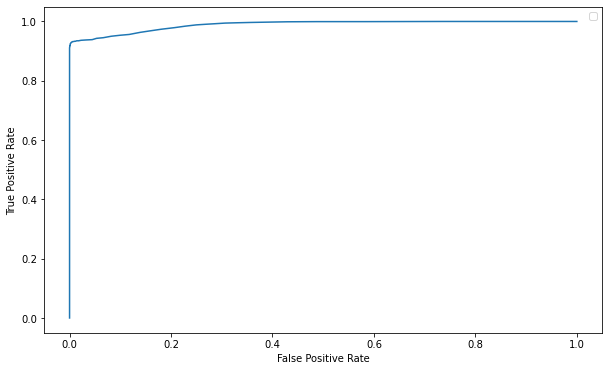

In [22]:
print('Accuracy Score : {}'.format(accuracy_score(y_valid, pred)))

lr_probs = roc_auc_score(y_valid, pred)
print('RoC Score : {}'.format(lr_probs))

lr_probs = model.predict_proba(x_valid)
lr_probs = lr_probs[:, 1]
fpr, tpr, _ = roc_curve(y_valid, lr_probs)

plt.figure(figsize=(10,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

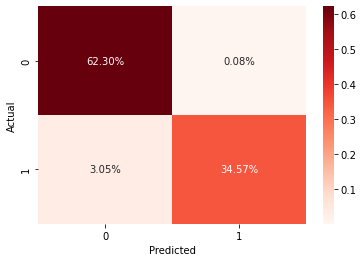

In [24]:
cf_matrix = confusion_matrix(y_valid, pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()